# Sparkify project

This workspace contains a **medium** subset (273MB) of the full dataset (12GB) provided by [Udacity](https://www.udacity.com/).<br>
We will use the small dataset to perform exploratory data analysis and build a prototype machine learning model using the [PySpark](https://spark.apache.org/docs/latest/api/python/index.html) API and the [Pyspark ML](https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html) package.


# Introduction

In the `Sparkify` notebook we used a tiny dataset. It's time to step things up with more data.

In this notebook, we will be using a medium subset (237MB) of the full dataset. 

The steps involved in analyzing the medium dataset and building the models are as follows:
- Load Data into Spark.
- Clean data.
- Explore the medium dataset and **compare its statistics with the mini dataset**.
- Create features based on the data explortation.
- Build models with [Pyspark ML](https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html) to predict which users will churn from Sparkify.

# Import libraries

In [1]:
# Pyspark
from pyspark.sql import SparkSession

from pyspark.sql.window import Window
import pyspark.sql.functions as f
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType,FloatType

# Spark MLlib
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes, LogisticRegression,RandomForestClassifier,GBTClassifier,\
                                      LinearSVC, DecisionTreeClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Pandas, numpy,...
import pandas as pd
import numpy as np
import datetime
from time import time

# Data Viz
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

import matplotlib.pyplot as plt
import seaborn as sns

# Stats
import math
import scipy.stats as stats
import random
from random import sample

# Create a Spark session

In [2]:
spark = SparkSession.builder.\
        appName("Sparkify_medium").\
        master("local").\
        getOrCreate()

spark

# Load and Clean Dataset
In this workspace, the dataset file is `medium_sparkify_event_data.json`. We will load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## Load data

In [3]:
sparkify_data_path = "./medium-sparkify-event-data.json"

df = spark.read.format("json").option("header","true").load(sparkify_data_path)

In [4]:
# Dataset size
print(f'Row count: {df.count()}')
print(f'Column count: {len(df.columns)}')

Row count: 543705
Column count: 18


In [5]:
# Schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## Duplicate data

In [6]:
duplicate_df = df.groupBy(df.columns).count().filter("count > 1")

print(f"Duplicate rows: {duplicate_df.count()}")

Duplicate rows: 0


## Invalid or missing data

In [7]:
def return_missing_values(df):
    """
    Shows the count of missing values for every column in a given data set.
    
    Args:
        df (DataFrame): The data set.
        
    OUTPUT:
        df_null (Pandas DataFrame): count of missing values per column.
    """
    dict_null = {column:df.filter(df[column].isNull()).count() for column in df.columns}
    df_null = pd.DataFrame(dict_null.items(),columns=['Column','Count']).\
              sort_values(by="Count",ascending=False).\
              set_index("Column")
    
    return df_null

In [8]:
return_missing_values(df)

,Count
Column,
artist,110828
length,110828
song,110828
firstName,15700
gender,15700
userAgent,15700
lastName,15700
location,15700
registration,15700


🔑 **Note** 

- There are no NANs in the **`userId`** or **`sessionId`** columns. 

- However, there are **15.7K** missing values in the user-related columns (*firstName*, *gender*, *lastName*, *location*, *registration* and *userAgent*) and **111K** missing values in the song/artist columns..<br>

Let's check the `userId`, where the associated user attributes are missing.

In [9]:
user_related_columns = ['userId','firstName','lastName','gender','userAgent','location','registration']

df_user_null = df.select(user_related_columns)

for col in user_related_columns[1:]: 
    df_user_null = df_user_null.select(user_related_columns).filter(df_user_null[col].isNull())

df_user_null.select("userId").distinct().collect()[0]

Row(userId='')

As with the mini-dataset, the userId with no information is `''`.

#### What type of user has missing attributes?

In [10]:
print("Authentication for missing users:")
df.where("userId = ''").groupBy("auth").count().show()

print("Authentication for other users:")
df.where("userId != ''").groupBy("auth").count().show()

Authentication for missing users:
+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out|15606|
|     Guest|   94|
+----------+-----+

Authentication for other users:
+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    99|
|Logged In|527906|
+---------+------+



🔑 **Note** 

- Rows with missing user are either logged out or guest. This explains why we do not have details of these users.<br>
- Since our goal is to predict **churners**, we will remove these rows because we don't know who they belong to.

### Drop rows containing missing users

In [12]:
df_clean = df.filter(df['userId']!='')

# We could also apply the following filter
# df_clean = df_clean.filter(df_clean.firstName.isNotNull())

In [13]:
# display missing values
return_missing_values(df_clean)

,Count
Column,
artist,95128
song,95128
length,95128
page,0
userAgent,0
ts,0
status,0
sessionId,0
registration,0


There are approximately **95K** logs that are missing artist and song information. Let's take a look at these features in relation to the `page`.

#### Missing values in artist, length and song

In [14]:
# Page events where artist, song and length are null

isNull_ = df_clean['artist'].isNull() | df_clean['song'].isNull() | df_clean['length'].isNull()
df_clean.filter(isNull_).select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [16]:
# Page events where artist, song and length are not null:

isNotNull_ = df_clean['artist'].isNotNull() & df_clean['song'].isNotNull() & df_clean['length'].isNotNull()
df_clean.filter(isNotNull_).select("page").dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



🔑 **Note** 

Only the `NextSong` event on the page, i.e. the playing of a song, contains information about the artist and the song, which makes sense: **Missing artist and song information is linked to non-song events.** Threfore, we will not drop these rows with missing values.


### Drop redundant columns
Since we have the userId, we don't need the firstName and lastName for our analysis and our models.

In [15]:
df_clean = df_clean.drop('firstName')
df_clean = df_clean.drop('lastName')

So far, we've loaded and cleaned the data by deleting the missing users and dropping redundant columns. Now let's create columns for dates and locations.

### Add columns: `time` and `date`

In [16]:
# 1. Create a user defined function for formating the timestamp
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

# 2. Apply the udf on the ts column
df_clean = df_clean.withColumn("time", get_time(df_clean.ts))

# 3. Apply the udf on the registration column
df_clean = df_clean.withColumn("registration_time", get_time(df_clean.registration))

df_clean.describe(["time","registration_time"]).toPandas().set_index("summary").loc[["count","min","max"]]

,time,registration_time
summary,,
count,528005,528005
min,2018-10-01 01:00:11,2017-11-05 04:56:33
max,2018-12-01 01:01:06,2018-11-24 16:37:54


In [19]:
# 1. Create a user defined function for formating the timestamp
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d"))

# 2. Apply the udf on the ts column
df_clean = df_clean.withColumn("date", get_date(df_clean.ts))

# 3. Apply the udf on the registration column
df_clean = df_clean.withColumn("registration_date", get_date(df_clean.registration))

df_clean.describe(["date","registration_date"]).toPandas().set_index("summary").loc[["count","min","max"]]

,date,registration_date
summary,,
count,528005,528005
min,2018-10-01,2017-11-05
max,2018-12-01,2018-11-24


### Split `location` column into `city` and `state` columns

In [20]:
df_clean = df_clean.withColumn('city', f.split(df_clean['location'], ',')[0])
df_clean = df_clean.withColumn('state', f.split(df_clean['location'], ',')[1])
df_clean = df_clean.drop('location')

df_clean.describe(["state","city"]).show()

+-------+------+------------+
|summary| state|        city|
+-------+------+------------+
|  count|528005|      528005|
|   mean|  null|        null|
| stddev|  null|        null|
|    min|    AK|       Akron|
|    max|    WV|York-Hanover|
+-------+------+------------+



In [21]:
# Let's print the schema after cleaning and adding columns
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- registration_time: string (nullable = true)
 |-- date: string (nullable = true)
 |-- registration_date: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)



# Exploratory Data Analysis

##  Preliminary analysis

In [29]:
# Count of unique users
unique_users = df_clean.select('userId').dropDuplicates().count()

# Count of unique sessions
unique_sessions = df_clean.select('sessionId').dropDuplicates().count()

# Obs
num_obs = df_clean.count()

print(f"Unique Users : {unique_users}")
print(f"Unique Sessions : {unique_sessions}")
print(f"Average interactions per user : {num_obs/unique_users}")

Unique Users : 448
Unique Sessions : 4470
Average interactions per user : 1178.5825892857142


🔑 The medium dataset contains the logs of **448** unique users. Each user has around **1179** interactions.

##  Categorical features

Let's create a function to display the distribution of categorical features (gender, page, etc.) at log level and at user level.

In [22]:
# create a function to display categorical features using Plotly

def display_count_plots(rows_config, analysis_level):
    '''
    Plots the number of logs or users vs. the categorical features. 
    INPUT:
        rows_config (List): Each element in the list is a sub-list with the features to be plotted in each row.
                            If there is more than one feature in the sub-list, a subplot is used.
                            
                            Example: [['level','status'],['gender','method'],['page'],['state']]
                                     - The first row displays tow plots (level and status)
                                     - The third row displays one plot (page)
                                     
        analysis_level (String): value in ('Logs','Users')
        
    OUTPUT:
        Display plots using Plotly.
    '''
    
    for config in rows_config:

        if len(config) == 1:
            column = config[0]
            
            # Loge level analysis            
            if analysis_level=="Logs":
                category_counts = df_clean.groupBy(column).count().toPandas().sort_values(by="count",ascending=False)
                category_counts[column] = category_counts[column].astype(str)
                
            # User level analysis 
            else: # Aggregate data by userId
                category_counts = df_clean.select('userId', column).dropDuplicates().groupby(column).count().toPandas()\
                      .sort_values(by="count",ascending=False)
            category_counts[column] = category_counts[column].astype(str)
                
            fig = px.bar(category_counts, x=column, y= "count", title=analysis_level+" per "+column,height=500)
            # fig.update_xaxes(title="")
            fig.show()

        # Subplots        
        else:        
            # Initialize figure with subplots                                                           
            fig = make_subplots(
                rows=1, cols=len(config),
                subplot_titles=tuple([analysis_level+" per "+config[k] for k in range(len(config))])
            )

            # Compute category_counts and Add traces     
            for k in range(len(config)):
                column = config[k]
                
                # Loge level analysis            
                if analysis_level=="Logs":
                    category_counts = df_clean.groupBy(column).count().toPandas().sort_values(by="count",ascending=False)
                    category_counts[column] = category_counts[column].astype(str)   
                    
                # User level analysis
                else:
                    category_counts = df_clean.select('userId', column).dropDuplicates().groupby(column).count().toPandas()\
                          .sort_values(by="count",ascending=False)
                    category_counts[column] = category_counts[column].astype(str)

                # Add traces
                fig.add_trace(
                    go.Bar(x=category_counts[column],y=category_counts["count"], 
                           marker=dict(color="#636EFA"),showlegend=False,name=""),
                    row=1, col=1+k
                )
                
                # Update title position
                fig.layout.annotations[k].update(y=1.1)

            # Update_layout            
            fig.update_layout(
                xaxis_title_text="", # xaxis label
                yaxis_title_text="count", # yaxis label
                margin=dict(r=10, t=50, b=40, l=60),
                height=300)

            fig.show()

### Log level analysis

In [23]:
rows_config = [['level','gender'],['status','method'],['page'],['state']]

display_count_plots(rows_config,"Logs")

🔑 **Note:** According to log events:

- `NextSong`, i.e. listening to a song, is by far the most used page.
- There are more logs for women and more logs for paid services.

### User level analysis

In [24]:
rows_config = [['level','gender'],['status','method'],['page'],['state']]

display_count_plots(rows_config,"Users")

🔑 **Note** 

**As with the mini dataset:**
- More users with the **free** service (370 compared with 321 for the **paid** service).
- Although the total number of logs related to **errors** is too small (see log level analysis above), **223** users (almost 50% of all users) have encountered errors leading to page 404.
- 34% of the users are located in the big **cities** (CA, TX, NY-NJ-PA and FL).

**Unlike the mini dataset:**
- As with the mini dataset, there are fewer **female** users than males (198 vs. 250 for males), **but unlike the mini dataset**, there are fewer female interactions (225K vs. 303K).

## Numeric features
We will display the number of interactions, number of sessions and session duration per user.

### Number of Interactions, sessions and session duration per user

In [25]:
def plot_hist_with_boxplot(df_stats, column, title, xaxis_title,yaxis_title,height=300 ):
    """
    Plots a Histogram with Boxplot.
    
    Args:
        df_stats (pandas DataFrame): The data set.
        column (str): The name of the target column.  
        title (str): The title of the plot.
        height (int); Height of the plot.
        
    Returns:
        None
    """

    # Initialize figure with subplots  
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=(title," ") ,
                        column_widths=[0.7, 0.3]
                       )

    # Add Histogram
    fig.add_trace(
        go.Histogram(x=df_stats[column], marker=dict(color="#636EFA"),showlegend=False,name=""),
        row=1, col=1
    )
    fig.layout.annotations[0].update(y=1.05)

    # Add Boxplot
    fig.add_trace(
        go.Box(y=df_stats[column], marker=dict(color="#636EFA"),showlegend=False,name=""),
        row=1, col=2
    )
    fig.layout.annotations[1].update(y=1.05)

    # Update_layout
    fig.update_layout(
        xaxis_title_text=xaxis_title, # xaxis label
        yaxis_title_text=yaxis_title, # yaxis label
        margin=dict(r=10, t=40, b=40, l=60),
        height=height)

    fig.show()

In [26]:
# 1. Number of interactions per user
df_user_interactions = df_clean.groupby('userId').count().toPandas()

plot_hist_with_boxplot(df_user_interactions,"count","Interactions per User","Count","Frequency")



# 2. Number of sessions per user
df_user_sessions = df_clean.select('userId', 'sessionId').dropDuplicates().groupby('userId').count().toPandas()\
                   .sort_values(by="count",ascending=False)

plot_hist_with_boxplot(df_user_sessions,"count","Sessions per user","Count","Frequency")


# 3. Session duration in minutes
df_session_duration = df_clean.groupby('userId', 'sessionId') \
                    .agg(((f.max('ts') - f.min('ts'))/60000).alias('duration')) \
                    .select('duration').toPandas() \
                    .sort_values(by="duration",ascending=False)

plot_hist_with_boxplot(df_session_duration,"duration","Session Duration (minutes) per user","minutes","Frequency")

🔑 **Note** 

We can see that there is a lot of variability regarding the number of `interactions`, `sessions` and `session duration` per user.

The distribution of these features are **right-skewed**. Some extreme outliers can be detected. <br>

We will not drop these `outliers`, as they are not errors in the logs, but reflect some user behaviour.

### Distribution of Dates

In [27]:
display_count_plots([['date']],"Logs")

🔑 **Note** 

**As with the mini dataset:**

- The medium Sparkify dataset essentially consists of logs collected in October 2018 and November 2018.

- Less logs are observed on Sundays (less than 6000 logs per day).

### Summary of the preliminary analysis

🔑 **Summary** 

> This dataset contains the logs of **448** unique users. Each user has around **1179** interactions.<br><br>
> **As with the mini dataset:**
> - The medium Sparkify dataset consists of logs collected in October 2018 and November 2018.
> - `NextSong`, i.e. listening to a song, is by far the most used page.    
> - There are more logs for women and more logs for paid services.
> - More users with the **free** service (370 compared with 321 for the **paid** service).
> - Although the total number of logs related to **errors** is too small (see log level analysis above), **223** users (almost 50% of all users) have encountered errors leading to page 404.
> - 34% of the users are located in the big **cities** (CA, TX, NY-NJ-PA and FL).
> - The distribution of `interactions`, `sessions` and `session duration` per user are **right-skewed**. Some extreme outliers can be detected. We have decided not to drop these `outliers`, as they are not errors in the logs, but reflect some user behaviour.<br><br>
>
> **Unlike the mini dataset:**
> - As with the mini dataset, there are fewer **female** users than males (198 vs. 250 for males), **but unlike the mini dataset**, there are fewer female interactions (225K vs. 303K). 



**Now that we've carried out the preliminary analysis, let's define churn and analyse all these features against it.**

## Define Churn

We will look at two page events: `Cancellation Confirmation` and `Downgrade`.

In [30]:
# 1. Check the number of cancelled users:
users_cancel = df_clean.where(df_clean.page == 'Cancellation Confirmation').select('userId').dropDuplicates()

# 2. Check the number of users who downgrade the service:
users_downgrade = df_clean.where(df_clean.page == 'Submit Downgrade').select('userId').dropDuplicates()

# 3. Check the number of users who downgrade AND cancel the subscription:
users_cancel_downgrade = users_downgrade.intersect(users_cancel)

print(f"Users who cancelled the subscription: {users_cancel.count()}")
print(f"Users who downgraded the subscription: {users_downgrade.count()}")
print(f"Users who cancelled and downgraded the subscription: {users_cancel_downgrade.count()}")
print(f"Churn rate: {np.round(users_cancel.count()/unique_users*100,1)}%")

Users who cancelled the subscription: 99
Users who downgraded the subscription: 97
Users who cancelled and downgraded the subscription: 21
Churn rate: 22.1%


🔑 **Note** 

Two types of churners can be defined: 
- those who have downgraded their account from paid to free (97 users)
- those who cancelled the service altogether (99 users).<br> 

I've decided to only take the latter into account, because the former are still using the service, even for free, and aren't definitively lost.
<br><br>
The churn rate is about **22.1%** (It was around **23.1%** in the mini dataset). This dataset is quite **unbalanced**.

Let's create 4 columns:
1. `churn_event`: this is a binary variable which returns 1 if the page is "Confirm cancellation", otherwise it returns 0.
2. `churn`: it returns 1 for all user records that subsequently cancelled the service, otherwise it returns 0.
3. `downgrade_event`: this is a binary variable which returns 1 if the page is "Submit Downgrade", otherwise it returns 0. 
4. `downgrade_count`: it returns the total number of downgrade events per user.

To calclulate the `churn` and `downgrade_count` columns, we will partition df_clean by userId using `Window.partitionBy`.

In [31]:
# Partition df_clean by userId
user_window = Window.partitionBy('userID')\
            .orderBy(f.desc('ts')) \
            .rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [32]:
# 1. UDF - function for the cancel event 
cancel_event = udf(lambda x : 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

# 2. Create binary churn_event variable
df_clean = df_clean.withColumn('churn_event',cancel_event('page'))

# 3. Create `churn` column that indicicates all of the records of users who later cancel the service.
df_clean = df_clean.withColumn('churn',f.max('churn_event').over(user_window))

In [33]:
# 1. UDF - function for the downgrade event 
downgrade_event = udf(lambda x : 1 if x == 'Submit Downgrade' else 0, IntegerType())

# 2. Create binary downgrade_event variable
df_clean = df_clean.withColumn('downgrade_event',downgrade_event('page'))

# 3. Create `downgrade' column. This will sum up all downgrade events per user.
df_clean = df_clean.withColumn('downgrade_count',f.sum('downgrade_event').over(user_window))

Let's look at the distribution of  **`downgrade_count`** vs. **`churn`**.

In [34]:
print("Number of logs per downgrade_count and churn.")
df_clean.groupBy("churn","downgrade_count").count().toPandas().sort_values(by="churn")

Number of logs per downgrade_count and churn.


,churn,downgrade_count,count
1,0,2,20714
3,0,0,269363
4,0,1,134282
0,1,0,57349
2,1,3,2955
5,1,1,27272
6,1,2,16070


In [39]:
print("Number of unique users per downgrade_count and churn.")
df_clean.dropDuplicates(["userId"]).groupby(["churn", "downgrade_count"]).count().sort("churn")\
.toPandas().sort_values(by="churn")

Number of unique users per downgrade_count and churn.


,churn,downgrade_count,count
0,0,2,12
1,0,0,273
2,0,1,64
3,1,0,78
4,1,3,1
5,1,1,14
6,1,2,6


Users who downgrade their service do not necessarily churn. Henceforth, churners are those who cancelled the service altogether.

# <a name="eda"></a> Exploratory data analysis
Here, we will perform in-depth exploratory data analysis to observe the behavior for users who stayed vs. users who churned.

## Explore categorical features

To explore and analyse categorical features, let's create `churn_analysis`: a function to display users, interactions and churn rate against the categorical feature.

In [35]:
def churn_analysis(df_stats,feature,log_level_analysis=False,sort_by_users=True,xAxis_toStr=False
                   ,height1=300,height2=400,display_churn_rate=True,sort_by_count = True):
    '''
    Return the number of interactions and churn rate vs. the categorical feature.
    
    INPUT:
        df_stats (Pyspark DF): the pyspark dataframe.
        feature (str): feature to analyse.
        log_level_analysis (boolean): wether or not displaying log level charts, defautl=False
        sort_by_users (boolean): sort stats by user, default=True
        xAxis_toStr (boolean): whether or not to convert the xAxis to a string, default = False.
        height1 (int): height of the user level charts, dfault=300
        height2 (int): height of the log level charts, dfault=400
        display_churn_rate (boolean): wether or nor to display churn rate, default=True.
        sort_by_count (boolean): whether or not to sort count of logs dataframe, default = True
    
    OUTPUT:
        churn_stats (Pandas DF): number of users (churners and non-churners) and the churn rate.
    '''
    
    # 1. Users count (churners/non-churners) and churn rate%
    users_count = df_stats.select("userId","churn", feature).drop_duplicates()\
                 .groupBy(["churn",feature]).count().toPandas()
    
    if xAxis_toStr:
        users_count[feature] = users_count[feature].astype(str) 
    
    churn_stats = pd.pivot_table(users_count, values='count', index=[feature],columns=['churn'],\
                                 aggfunc=np.sum, fill_value=0)    
    churn_stats["churn rate"] = 100*churn_stats[1] /(churn_stats[1] + churn_stats[0])
    
    if sort_by_users:
        churn_stats = churn_stats.sort_values(by=0,ascending=False) # sort by non-churners value
    else:
        churn_stats = churn_stats.sort_index() # sort by feature (which is the index of the churn_stats DF)
    

    # 2. Display count_users and churn_rate
    
    # If the number of categories is greater than 7, we will not use sub-plots for better presentation.
    if len(churn_stats)>7: 
              
        # Add counts        
        fig = go.Figure(data=[
            go.Bar(name='non-churners', x=churn_stats.index, y=churn_stats[0]),
            go.Bar(name='churners', x=churn_stats.index, y=churn_stats[1])
        ])
        fig.update_layout(barmode='group',title="Users vs. "+feature,
                          margin=dict(r=10, t=40, b=40, l=20),
                          height=height1)
        fig.update_yaxes(title="count")
        fig.show()
        
        # Add churn rate
        if display_churn_rate:            
            fig = go.Figure(data=[
                go.Bar(name='churn rate', x=churn_stats.index, y=churn_stats["churn rate"],marker=dict(color="#FFA15A") )
            ])
            fig.update_layout(title="Churn rate vs. "+feature,
                              margin=dict(r=10, t=40, b=40, l=20),
                              height=height1)
            fig.update_yaxes(title="%")
            fig.show()
    
    else:
        # Use Subplots, if number of categories < 7 
        
        # Initialize figure with subplots  
        fig = make_subplots(rows=1, cols=2,
                            subplot_titles=("Users vs. "+feature,"Churn rate vs. "+feature) ,
                            column_widths=[0.5, 0.5],
                            horizontal_spacing=0.15
                           )

        # Add counts
        fig.add_trace(
            go.Bar(name='non-churners', x=churn_stats.index, y=churn_stats[0]),
            row=1, col=1
        )

        fig.add_trace(
            go.Bar(name='churners', x=churn_stats.index, y=churn_stats[1]),
            row=1, col=1
        )
        # Update title positions
        fig.layout.annotations[0].update(y=1.05)

        # Add churn rate
        if display_churn_rate:
            fig.add_trace(
                go.Bar(name='churn rate', x=churn_stats.index, y=churn_stats["churn rate"],marker=dict(color="#FFA15A") ),
                row=1, col=2
            )        
            fig.layout.annotations[1].update(y=1.05)

        # Edit axis labels
        fig['layout']['yaxis']['title']='count'
        fig['layout']['yaxis2']['title']='%'

        # Update_layout
        fig.update_layout(
            margin=dict(r=10, t=40, b=40, l=20),
            height=height1)

        fig.show()   

    if log_level_analysis:
        # create Pandas dataframe
        logs_count = df_stats.groupBy("churn",feature).count().toPandas().sort_values(by=["churn",feature])
        if sort_by_count:
            logs_count = logs_count.sort_values(by=["count"],ascending=False)
            
        logs_count[feature] = logs_count[feature].astype(str) 

        # plot 
        fig = px.histogram(logs_count, x=feature, y="count",
             color='churn', barmode='group',
             height=height2,title="Count of logs per "+feature)
        fig.update_yaxes(title="count")
        fig.show()
        
    return churn_stats

###  Churn vs. gender

The categorical variable **`gender`** can take one of two possible values, `F`or `M`.

In [36]:
stats_churn_gender = churn_analysis(df_clean,"gender",log_level_analysis = False)

🔑 **Note** 

**As with the mini dataset:**
- there are more males than females.

**Unlike the mini dataset:**
- females are more likely to churn (22.72% vs. 21.6% respectively).


###  Churn vs. level
The categorical variable **`level`** can take one of two possible values, `free`or `paid`.

In [37]:
stats_churn_level = churn_analysis(df_clean,"level",log_level_analysis = False)

🔑 **Note** 

There are more free users than paid users, and .

**As with the mini dataset:**
- There are more free users than paid users 

**Unlike the mini dataset:**
- Paid users are more likely to churn (23.36% vs. 22.2% for free users)


### Churn vs. status
The categorical variable **`status`** can take one of 3 possible values: 307, 200 & 404.

In [38]:
stats_churn_status = churn_analysis(df_clean,"status",log_level_analysis = True,xAxis_toStr=True)

🔑 **Note** 

**As with the mini dataset:**
- Status `404`has the lowest churn rate at 17.9% (compared with 22% for the other statuses).<br>This is due to the fact that users (churners or non-churners) rarely encounter a '404 - Page not found' problem. 

### Churn vs. userAgent

In [40]:
# Let's show some userAgents
try:
    print(df_clean.select("userAgent").sample(fraction=0.01).take(5)) # random selection
except:
    print(f"userAgent column does not exist!")

[Row(userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"'), Row(userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0'), Row(userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0'), Row(userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"'), Row(userAgent='Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7.0; rv:11.0) like Gecko')]


Let's create two columns:
- **browser**: values in (Safari, Firefox...)
- **device**: values in (Windows, Mac...)

In [41]:
try:
    # 1. device
    get_device = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])

    df_clean = df_clean.withColumn("device", get_device(df_clean.userAgent))

    df_clean.groupby("device").count().show()

    # 2. browsers
    get_browser = udf(lambda x: x.split(" ")[-1].split("/")[0])

    df_clean = df_clean.withColumn("browser", get_browser(df_clean.userAgent))

    df_clean.groupby("browser").count().show()

    # 3. drop userAgent
    df_clean = df_clean.drop("userAgent")
except:
    pass

+----------+------+
|    device| count|
+----------+------+
|      iPad| 16004|
|       X11| 25028|
|    iPhone| 14481|
| Macintosh|202059|
|compatible| 21777|
|   Windows|248656|
+----------+------+

+-------+------+
|browser| count|
+-------+------+
|Firefox|113562|
| Safari|376525|
|  Gecko| 16141|
|Trident| 21777|
+-------+------+



In [42]:
# Churn vs. device

stats_churn_device = churn_analysis(df_clean,"device",log_level_analysis = False,height1=350)

In [43]:
# Churn vs. browser

stats_churn_browser = churn_analysis(df_clean,"browser",log_level_analysis = False,height1=350)

🔑 **Note**

**As with the small dataset:**

- Churn rate is higher for `Firefox` (27% vs 21% for Safari). 
- Churn rate is higher for the `iphone` (**61%** vs 22% for Windows and MAC). The churn rate for iphone in the small dataset is **31%** (the gap is wide between the two datasets).<br>**We can conclude that there are potential problems with the application on iPhone devices**.

**Unlike the small dataset:**
- `X11` churn rate is lower than Windows and MAC at 19%. In the small data set it was the highest at 41.7%!

### Churn vs. state

In [44]:
stats_churn_state = churn_analysis(df_clean,"state",log_level_analysis = True,height1=400,height2=500)

🔑 **Note**

**As with the small dataset:**

- Most users are located in California, Texas, New York/New Jersey/Penn and Florida.
- The churn rate could be 100% for some states where the number of users is too small (e.g. 1 user in VT and TN-VA).
- California (CA) has the most events for both groups.

**Unlike the small dataset:**
- In the small dataset, we saw that there is a bigger proportion of logs for churners in CO, MS, KY, OH and WA.<br>This is not the case according to the medium dataset.

So far we have analysed churn against the categorical columns: `Gender`, `Level Status`, `UserAgent` and `State`.

We will now analyse the effect of the time level. But first we need to create new columns for the time level (hour, day and weekday).

### Churn vs. time level (weekday, day and hour)

In [45]:
# Calculate the hour, day, weekday of the timestamp ts
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour, IntegerType())
df_clean = df_clean.withColumn("hour", get_hour(df_clean.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day, IntegerType())
df_clean = df_clean.withColumn("day", get_day(df_clean.ts))

get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).weekday(), IntegerType())
df_clean = df_clean.withColumn("weekday", get_weekday(df_clean.ts))

df_clean.describe(["weekday","day","hour"]).toPandas().set_index("summary").loc[["count","min","max"]]

,weekday,day,hour
summary,,,
count,528005,528005,528005
min,0,1,0
max,6,31,23


In [50]:
# Churn vs. weekday

stats_churn_weekday = churn_analysis(df_clean,"weekday",log_level_analysis = True,sort_by_users=False,sort_by_count=False)

In [51]:
# Churn vs. day

stats_churn_day = churn_analysis(df_clean,"day",log_level_analysis = True,sort_by_users=False,sort_by_count=False)

In [49]:
# Churn vs. hour

stats_churn_hour = churn_analysis(df_clean,"hour",log_level_analysis = True,sort_by_users=False,sort_by_count=False)

🔑 **Note**

**As with the small dataset:**
- Churn is higher in the first two weeks of the month.
- More logs from noon to midnight.

### Churn vs. page events

First, let's plot the distribution of the number of pages using box plots through its quartiles (median, lower and upper quartiles).

In [52]:
# 1. Create a pivot table of page events
pages = df_clean.groupBy(['userId']).pivot('page').count().fillna(0)
pages_df = pages.toPandas()
pages_df = pages_df.rename(columns={"Cancellation Confirmation": "churn"})


# 2. Plot BoxPlot for each Page

pages_list = ['Thumbs Down','Thumbs Up','Add Friend','Add to Playlist',
              'Roll Advert','Error','Downgrade','NextSong',
              'Help','Home','Logout','Save Settings','Settings',
              'Submit Downgrade','Submit Upgrade','About'
             ]

nb_cols = 4 # number of columns to display per row

for j in range(0,math.ceil(len(pages_list)/nb_cols)): # number of rows to display
    
    cols = pages_list[j*nb_cols:(j+1)*nb_cols] # List of columns to display for row j  
    
    # initialise subplot
    fig = make_subplots(rows=1, cols=nb_cols, subplot_titles=tuple(cols) )
    
    for i, col in enumerate(cols):
        try:
            # Non-churners
            fig.add_trace(
                go.Box(y=pages_df[pages_df.churn==0][col], marker=dict(color="#636EFA"), showlegend=False,name="non-churners"),
                row=1, col=i+1
            )   
            # Churners
            fig.add_trace(
                go.Box(y=pages_df[pages_df.churn==1][col], marker=dict(color="#EF553B"), showlegend=False,name="churners"),
                row=1, col=i+1
            ) 
            fig.layout.annotations[i].update(y=1.05) # update title position
        except:
            pass

    # Update_layout
    if j==0:
        fig.update_layout(
            title_text="<b>Churn vs. page events</b>",
            title_x=0.5,
            title_font_color="black",
            font=dict(color="black")  ,
            margin=dict(r=20, t=90, b=40, l=20),
            height=275
        )
    else:
        fig.update_layout(
            font=dict(color="black")  ,
            margin=dict(r=20, t=40, b=40, l=20),
            height=275)
        
        
    fig.show()

🔑 **Note** 

**As with the small dataset:**
- Churners have less page events than non-churners: They add fewer friends and playlists, listen to fewer songs...

- Interestingly, churners also made fewer errors, which on second thought makes sense as they are less active and therefore less likely to make errors.

**We need to convert the numbers into ratios by dividing them by the total number of page events.<br> We could also divide them by the user's activity time, measured in hours, to get hourly statistics.**

In [53]:
stats_pages_churners = df_clean.filter("churn=1").groupBy('page').count().sort(f.desc('count')).toPandas().set_index('page')
stats_pages_non_churners = df_clean.filter("churn=0").groupBy('page').count().sort(f.desc('count')).toPandas().set_index('page')
# merge the two DF
stats_pages = stats_pages_churners.merge(stats_pages_non_churners,left_index=True,right_index=True)
stats_pages.columns = ['count (churners)','count (non-churners)']

# Calculating ratios by dividing counts by the total number of pages
stats_pages['ratio (churners)'] = round((stats_pages['count (churners)'] /  stats_pages['count (churners)'].sum()) * 100,2)
stats_pages['ratio (non-churners)'] = (stats_pages['count (non-churners)'] /  stats_pages['count (non-churners)'].sum()) * 100
stats_pages['delta(%)'] = stats_pages['ratio (churners)'] - stats_pages['ratio (non-churners)']

stats_pages.style.bar(subset='delta(%)', align='mid', color=['#2F7FBC','#d8576b',])

,count (churners),count (non-churners),ratio (churners),ratio (non-churners),delta(%)
page,,,,,
NextSong,84359,348518,81.550000,82.128104,-0.578104
Thumbs Up,4300,19526,4.160000,4.601293,-0.441293
Home,3778,15311,3.650000,3.608030,0.041970
Add to Playlist,2259,10090,2.180000,2.377704,-0.197704
Roll Advert,2186,5587,2.110000,1.316574,0.793426
Add Friend,1537,6550,1.490000,1.543504,-0.053504
Logout,1184,4806,1.140000,1.132532,0.007468
Thumbs Down,1156,3755,1.120000,0.884864,0.235136
Downgrade,831,2980,0.800000,0.702236,0.097764


🔑 **Note** 

**As with the small dataset:**
- The most used pages are quite similar for churners and non-churners. `NextSong`, `Thumbs Up`, `Home`,`Add to Playlist` and `Roll Advert` are the top 5 pages . More than 81% of logs for both groups are with page type `NextSong`, which relates to listening to music.

- The most significant difference in **proportion** between churners and non-churners concerns the `Thumbs down` and the `Roll advert` pages with a delta of **0.9%** and **0.23%** respectively.

**Interestingly, both datasets have the same statistics for the top 5 pages and the `Thumbs down` and `Roll Advert` pages.**

## Explore numerical features

Here, we will explore the `number of sessions`, `unique songs` and `artists` as well as `length` for churners and non-churners.

We will start by creating a function to display histograms and describe these features (min,max,mean...)

In [54]:
def analyse_numerical_feature(df_feature,metric,nbins=50,update_logs=True,barmode="overlay",
                              histnorm="percent",height=400):
    '''
    Shows the distribution of the numerical feature and calculates its descreptive statistics.
    
    INPUT:
        df_feature (Pyspark DF): the pyspark dataframe containing the numerical feature to anlyze.
        metric (str): feature to analyse.
        nbins (int): number of bins of the histogram.
        update_logs (boolean): shows logs distribution.
        barmode (str): One of 'group', 'overlay' or 'relative', default 'relative'.
                       **Plotly descreption**: In 'overlay' mode, bars are drawn on top of one another.
        histnorm (str):  One of 'percent', 'probability', 'density', or 'probability', default 'percent'.
                         **Plotly descreption**: If 'percent', the output of `histfunc` for a given bin is divided by 
                         the sum of the output of `histfunc` for all bins and multiplied by 100.         
        height (int): height of the chart, dfault=400        
      
    OUTPUT:
        metrics (Pandas DF): the descreptive statistics of the analyzed feature.
    '''
             
    # 1. Plot Histogram
    
    fig = px.histogram(df_feature.toPandas(), x=metric, color="churn", nbins=nbins,barmode=barmode,histnorm=histnorm)
    
    # update yaxis title
    if histnorm=="percent":
        yaxis_title = "% of users"
    else:
        yaxis_title = "count of users"
        
    # update layout
    fig.update_layout(
                      #barmode='overlay', #stack
                      title="<b>Churn vs. "+metric+"</b>",
                      title_x=0.5,
                      title_font_color="black",
                      font=dict(color="black")  ,
                      xaxis_title_text=metric, # xaxis label
                      yaxis_title_text=yaxis_title, # yaxis label
                      margin=dict(r=10, t=50, b=40, l=60),
                      height=height)
    fig.show()
    
    # 2. Describe df_feature
    feature_descreption = df_feature.toPandas().pivot(index='userId', columns='churn', values=metric)\
                          .describe()\
                          .applymap(lambda x: f"{x:0.0f}") #round values
    
    q1_0 = feature_descreption.loc["25%"][0] # lower quartile for non-churners
    q1_1 = feature_descreption.loc["25%"][1] # lower quartile for churners
    median_0 = feature_descreption.loc["50%"][0] # median for non-churners
    median_1 = feature_descreption.loc["50%"][1] # median for churners
    mean_0 = feature_descreption.loc["mean"][0] # mean for non-churners
    mean_1 = feature_descreption.loc["mean"][1] # mean for churners
    q3_0 = feature_descreption.loc["75%"][0] # upper quartile for non-churners
    q3_1 = feature_descreption.loc["75%"][1] # upper quartile for churners
    std_0 = feature_descreption.loc["std"][0] # std for non-churners
    std_1 = feature_descreption.loc["std"][1] # std for churners
    
    metrics = {"metric":metric,
               "q1_0":q1_0,
               "q1_1":q1_1,
               "median_0":median_0,
               "median_1":median_1,
               "mean_0":mean_0,
               "mean_1":mean_1,
               "q3_0":q3_0,
               "q3_1":q3_1,
               "std_0":std_0,
               "std_1":std_1
            }
    
    print(f"`{metric}` description:")
    print(f"The median for churners is ({median_1}) vs. ({median_0}) for non-churners ")
    print(f"The mean for churners is ({mean_1}) vs. ({mean_0}) for non-churners ")
    print(f"The lower quartile for churners is ({q1_1}) vs. ({q1_0}) for non-churners ")
    print(f"The upper quartile for churners is ({q3_1}) vs. ({q3_0}) for non-churners ")
    print(f"The std for churners is ({std_1}) vs. ({std_0}) for non-churners ")
    
    return metrics

### Churn vs. num_sessions

In [55]:
df_user_sessions = df_clean.select('userId', 'churn' ,"sessionId").dropDuplicates().groupby('userId','churn').count()
df_user_sessions = df_user_sessions.withColumnRenamed('count', "num_sessions")

stats_num_sessions = analyse_numerical_feature(df_user_sessions,'num_sessions',nbins=50,update_logs=True,
                         barmode="overlay",histnorm="percent",height=400)

`num_sessions` description:
The median for churners is (8) vs. (10) for non-churners 
The mean for churners is (12) vs. (14) for non-churners 
The lower quartile for churners is (4) vs. (5) for non-churners 
The upper quartile for churners is (16) vs. (19) for non-churners 
The std for churners is (13) vs. (13) for non-churners 


🔑 **Note** 

**Unlike the small dataset:**
- There is a no significant difference between the two groups (churners and non-churners) in terms of the std of **number of sessions**

**Note:** In the small dataset, there was a significant difference between the two groups: 9 for churners vs. 16 for non churners.

### Churn vs. number of distinct songs

In [56]:
df_user_songs = df_clean.select('userId', 'churn' ,"song").dropDuplicates().groupby('userId','churn').count()
df_user_songs = df_user_songs.withColumnRenamed('count', "count_unique_songs")

stats_unique_songs = analyse_numerical_feature(df_user_songs,'count_unique_songs',nbins=25,update_logs=True,
                         barmode="overlay",histnorm="percent",height=400)

`count_unique_songs` description:
The median for churners is (420) vs. (573) for non-churners 
The mean for churners is (758) vs. (880) for non-churners 
The lower quartile for churners is (162) vs. (195) for non-churners 
The upper quartile for churners is (1130) vs. (1232) for non-churners 
The std for churners is (863) vs. (952) for non-churners 


🔑 **Note** 

- **The variance in the data is more similar between the groups compared to the small dataset.**<br>This is due to a higher std for the churners (963 vs. 620 in the small dataset).<br> The std for active users is the same in both datasets (952).

### Churn vs. count_songs

In [57]:
df_user_songs = df_clean.select('userId', 'churn' ,"song").groupby('userId','churn').count()
df_user_songs = df_user_songs.withColumnRenamed('count', "count_songs")


stats_songs = analyse_numerical_feature(df_user_songs,'count_songs',nbins=25,update_logs=True,
                         barmode="overlay",histnorm="percent",height=400)

`count_songs` description:
The median for churners is (558) vs. (756) for non-churners 
The mean for churners is (1047) vs. (1216) for non-churners 
The lower quartile for churners is (204) vs. (245) for non-churners 
The upper quartile for churners is (1460) vs. (1599) for non-churners 
The std for churners is (1263) vs. (1412) for non-churners 


🔑 **Note** 

- **The variance in the data is more similar between the groups compared to the small dataset.**<br>This is due to a higher std for the churners (1263 vs. 852 in the small dataset).<br> The std for active users is almost the same in both datasets.

### Churn vs. number of distinct artists

In [58]:
df_user_artists = df_clean.select('userId', 'churn' ,"artist").dropDuplicates().groupby('userId','churn').count()
df_user_artists = df_user_artists.withColumnRenamed('count', "count_unique_artists")


stats_unique_artists = analyse_numerical_feature(df_user_artists,'count_unique_artists',nbins=25,update_logs=True,
                         barmode="overlay",histnorm="percent",height=400)

`count_unique_artists` description:
The median for churners is (383) vs. (500) for non-churners 
The mean for churners is (594) vs. (679) for non-churners 
The lower quartile for churners is (155) vs. (184) for non-churners 
The upper quartile for churners is (896) vs. (1004) for non-churners 
The std for churners is (587) vs. (636) for non-churners 


🔑 **Note** 

- **The variance in the data is more similar between the groups compared to the small dataset.**<br>This is due to a higher std for the churners (587 vs. 456 in the small dataset).<br> The std for active users is almost the same in both datasets.

### Churn vs. length

The numerical variable **`length`** represents how long a user listens to a song.  

In [59]:
df_clean.select(["churn", "length"]).groupby(["churn"])\
.agg(f.avg('length').alias('avg_length'),\
     f.median('length').alias('median_length'),\
     f.stddev('length').alias('stdev_length'),\
     f.max('length').alias('max_length'),\
     f.min('length').alias('min_length'),\
     (f.sum('length')/(60*60)).alias('sum_length'))\
.toPandas().round(1)

,churn,avg_length,median_length,stdev_length,max_length,min_length,sum_length
0,1,249.0,234.3,98.5,2594.9,4.0,5834.7
1,0,248.6,234.0,98.4,3024.7,0.8,24065.6


🔑 **Note** 

- The average session length is similar between the two groups in terms of median (235 vs. 234) and mean (249 vs. 249).

- The difference between churners and non-churners is in terms of the `sum_length`: the total time spent by a user listening to his favourite songs (5835 vs. 24066).

**This means that active users spend `4` times more minutes listening to music than churners, compared to `5` times in the small dateset.**

### Churn vs. days_since_registraion

In [60]:
# 1. User Defined Function
get_duration = udf(lambda x,y: float((x-y)/(1000*60*60*24))) # duration in days

# 2. Apply the User Defined Function to the ts variable
df_clean = df_clean.withColumn("days_since_registraion", get_duration(df_clean.ts, df.registration))
df_clean = df_clean.withColumn("days_since_registraion", df_clean["days_since_registraion"].cast(IntegerType()))

df_clean.describe("days_since_registraion").show()

+-------+----------------------+
|summary|days_since_registraion|
+-------+----------------------+
|  count|                528005|
|   mean|    62.509758430317895|
| stddev|     39.30138087865127|
|    min|                     0|
|    max|                   390|
+-------+----------------------+



In [61]:
df_days_since_registraion = df_clean.select('userId', 'churn' ,"days_since_registraion")\
                                .dropDuplicates().groupBy(['userId', 'churn'])\
                                .agg(f.max('days_since_registraion').alias('max_days_since_registraion'))

stats_days_since_registration = analyse_numerical_feature(df_days_since_registraion,'max_days_since_registraion',
                                                          nbins=25,update_logs=True,
                                                          barmode="overlay",histnorm="percent",height=400)

`max_days_since_registraion` description:
The median for churners is (60) vs. (77) for non-churners 
The mean for churners is (67) vs. (87) for non-churners 
The lower quartile for churners is (41) vs. (63) for non-churners 
The upper quartile for churners is (90) vs. (101) for non-churners 
The std for churners is (44) vs. (39) for non-churners 


🔑 **Note**

- Both the mean and the median differ noticeably in terms of the `days_since_registration`.
- **We still have a significant difference between the two groups (compared to the small data set).**.

So far, we've analyzed numerical features such as the number of songs, days since registration, etc. We noted that there is a significant difference between churners and non-churners.

However, when we googled key indicators for measuring **user engagement**, we found that `session length` and `session interval` are key indicators for mobile and web applications.

Examples of references can be found [here](https://simpleprogrammer.com/measure-user-engagement-in-mobile-apps/) and [here](https://uxcam.com/blog/mobile-app-engagement-metrics/#:~:text=Session%20interval&text=This%20metric%20helps%20you%20understand,longer%20intervals%20show%20lower%20interest).


### Churn vs. Avreage session length

One of the key metrics to track user engagement is the average session length. 

In [62]:
session_length = df_clean.select(["userId","churn","sessionId","ts"])\
            .groupby(["userId","churn","sessionId"])\
            .agg(((f.max("ts") - f.min("ts"))/(1000*60)).alias('minutes_per_session'))\
            .groupby(["userId","churn"])\
            .agg(f.mean("minutes_per_session").alias("avg_session_length (minutes)")     )

stats_session_length = analyse_numerical_feature(session_length,'avg_session_length (minutes)',nbins=25,update_logs=True,
                                                 barmode="overlay",histnorm="percent",height=400)

`avg_session_length (minutes)` description:
The median for churners is (259) vs. (242) for non-churners 
The mean for churners is (291) vs. (261) for non-churners 
The lower quartile for churners is (143) vs. (134) for non-churners 
The upper quartile for churners is (348) vs. (367) for non-churners 
The std for churners is (208) vs. (149) for non-churners 


🔑 **Note**

- Interestingly, the average session length is slightly higher for churned users compared to the small dataset.
- Unlike the small dataset, there is significant difference in terms of std.

### Churn vs. Session interval

In addition to average session length, **session interval** is also a key indicator for measuring user engagement in mobile and web applications. <br>It allows us to understand the frequency with which users interact with the app and therefore their level of engagement.

In [63]:
# Calculate session interval in minutes
session_interval = df_clean \
    .groupby('userId','churn','sessionId') \
    .agg(f.min('ts').alias('start_time'), f.max('ts').alias('end_time')) \
    .groupby('userId','churn') \
    .agg(f.count('userId').alias('count_sessions'), \
        ((f.max('end_time') - f.min('start_time'))/(1000*60*60)).alias('observation_time'), \
        (f.sum(f.col('end_time') - f.col('start_time'))/(1000*60*60)).alias('total_sessions_time')) \
    .where(f.col('count_sessions') > 1)

get_session_interval = udf(lambda x,y,z: (x-y)/(z-1)) 

session_interval = session_interval.withColumn("session interval (minutes)",\
                             get_session_interval(f.col('observation_time'),f.col('total_sessions_time'),\
                                                  f.col('count_sessions')))
session_interval = session_interval.withColumn("session interval (minutes)", \
                                               session_interval["session interval (minutes)"].cast(IntegerType()))
session_interval = session_interval.select("userId","churn","session interval (minutes)")

stats_session_interval = analyse_numerical_feature(session_interval,'session interval (minutes)',nbins=25,
                                                   update_logs=True,barmode="overlay",histnorm="percent",height=400)

`session interval (minutes)` description:
The median for churners is (57) vs. (113) for non-churners 
The mean for churners is (89) vs. (160) for non-churners 
The lower quartile for churners is (29) vs. (64) for non-churners 
The upper quartile for churners is (92) vs. (194) for non-churners 
The std for churners is (127) vs. (158) for non-churners 


🔑 **Note: We still have a significant difference between churners and non-churners in terms of `session interval`.**

**In order to keep track of all the statistics we have created, we will convert them to Pandas dataframes and save them to csv.**

In [64]:
stats_num_pd = pd.DataFrame([stats_num_sessions,stats_session_interval,stats_session_length,stats_songs,stats_unique_artists])
stats_num_pd['dataset']="medium"

# save stats_num_pd
stats_num_pd.to_csv("./statistics/stats_num_medium.csv",index=False)

# stats_num_pd

In [65]:
stats_cat_pd = pd.concat([stats_churn_gender.reset_index().rename(columns={'gender':'category'}).assign(feature='gender'),
                          stats_churn_level.reset_index().rename(columns={'level':'category'}).assign(feature='level'), 
                          stats_churn_browser.reset_index().rename(columns={'browser':'category'}).assign(feature='browser'),
                          stats_churn_status.reset_index().rename(columns={'status':'category'}).assign(feature='status')
                         ])

stats_cat_pd = stats_cat_pd[['feature','category','churn rate']]
stats_cat_pd['dataset']="medium"


# save stats_cat_pd
stats_cat_pd.to_csv("./statistics/stats_cat_medium.csv",index=False)

# stats_cat_pd

**Let us concatenate the statistics of mini and medium datasets:**

In [66]:
# numerical features
stats_num_mini = pd.read_csv("./statistics/stats_num_mini.csv")
stats_num_medium = pd.read_csv("./statistics/stats_num_medium.csv")
stats_num = pd.concat([stats_num_mini,stats_num_medium]).rename(columns={'mean_0':'mean (non-churners)',
                                                                        'mean_1':'mean (churners)',
                                                                        'std_0':'std (non-churners)',
                                                                        'std_1':'std (churners)'})

pd.pivot(stats_num, index='metric', columns='dataset',
         values=['mean (non-churners)','mean (churners)','std (non-churners)','std (churners)'])

mean (non-churners)       mean (churners)       \
dataset                                   medium  mini          medium mini   
metric                                                                        
avg_session_length (minutes)                 261   297             291  260   
count_songs                                 1216  1348            1047  863   
count_unique_artists                         679   751             594  520   
num_sessions                                  14    15              12   10   
session interval (minutes)                   160   146              89   70   

                             std (non-churners)       std (churners)       
dataset                                  medium  mini         medium mini  
metric                                                                     
avg_session_length (minutes)                149   174            208  184  
count_songs                                1412  1425           1263  852  
count_unique_artists                        636   633            587  456  
num_sessions                                 13    16             13    9  
session interval (minutes)                  158   140            127   54

In [67]:
# categorical features
stats_cat_mini = pd.read_csv("./statistics/stats_cat_mini.csv")
stats_cat_medium = pd.read_csv("./statistics/stats_cat_medium.csv")

stats_cat = pd.concat([stats_cat_mini,stats_cat_medium])

pd.pivot(stats_cat, index=['feature','category'], columns='dataset',
         values=['churn rate']).round(1)

churn rate      
dataset              medium  mini
feature category                 
browser Firefox        26.3  32.0
        Gecko          27.8  14.3
        Safari         20.8  21.5
        Trident        15.4   0.0
gender  F              22.7  19.2
        M              21.6  26.4
level   free           22.2  23.6
        paid           23.4  21.8
status  200            22.1  23.1
        307            22.2  23.3
        404            17.9  18.8

### Summary of exploratory data analysis to observe the behavior for users who stayed vs users who churned.

🔑 **Categorical features:**

**1. Unlike the mini dataset:**
- Females are more likely to churn (22.72% vs. 21.6% for men).
- Paid users are more likely to churn (23.36% vs. 22.2% for free users).
- `X11` churn rate is lower than Windows and MAC at 19%. In the small data set it was the highest at 41.7%!
- In the small dataset, we saw that there is a bigger proportion of logs for churners in CO, MS, KY, OH and WA.<br>This is not the case according to the medium dataset.

**Note: Aaccording to the the modelling done with the small dataset, these changes will not affect our model, as it is based on user behaviour rather than user characteristics.**


**2. As with the mini dataset:**
- Status `404`has the lowest churn rate at 17.9% (compared with 22% for the other statuses).<br>This is due to the fact that users (churners or non-churners) rarely encounter a '404 - Page not found' problem. 
- Churn rate is higher for `Firefox` (27% vs 21% for Safari). 
- Churn rate is higher for the `iphone` (**61%** vs 22% for Windows and MAC). Recall that the iPhone churn rate in the smaller dataset is **31%** (the gap between the two datasets is large).<br>**We can conclude that there are potential problems with the application on iPhone devices**.
- Most users are located in California, Texas, New York/New Jersey/Penn and Florida.
- The churn rate could be 100% for some states where the number of users is too small (e.g. 1 user in VT and TN-VA).
- Churners have less page events than non-churners: They add fewer friends and playlists, listen to fewer songs...
- The most used **pages** are quite similar for churners and non-churners. `NextSong`, `Thumbs Up`, `Home`,`Add to Playlist` and `Roll Advert` are the top 5 pages . More than 81% of logs for both groups are with page type `NextSong`, which relates to listening to music.
- The most significant difference in **proportion** between churners and non-churners concerns the `Thumbs down` and the `Roll advert` pages with a delta  **0.9%** and **0.23%** respectively.



🔑 **Numerical features:** 
- There is a no significant difference between the two groups (churners and non-churners) in terms of the std of **number of sessions**
- The variance in the number of songs and artists is more similar between the groups compared to the small dataset.<br>This is due to a higher std for the churners
- active users spend `4` times more minutes listening to music (`sum_length`) than churners, compared to `5` times in the small dateset.
- As with the small dataset, both the mean and the median differ noticeably in terms of the `days_since_registration`.

- Interestingly, the average `session length` is slightly higher for churned users compared to the small dataset. And unlike the small dataset, there is significant difference in terms of std.

- We still have a significant difference between churners and non-churners in terms of `session interval`.


# <a name="featureEng"></a>Feature Engineering
Now, we will build out the features the we find promising to train our models.

### Load and clean the medium dataset
Let's first reload and clean the medium dataset. <br>
Note: You can ignore the next cell if you have run the previous cells (ie. you have already loaded and cleaned the data).

In [68]:
# Load medium dataset
sparkify_data_path = "./medium-sparkify-event-data.json"  

df = spark.read.format("json").option("header","true").load(sparkify_data_path)

# Clean Dataframe; drop any missing user_id or session_id

df_clean = df.dropna(how='any', subset=['userId', 'sessionId'])
df_clean = df.filter(df['userId']!='')


# Calculate the date, hour, day, weekday of the timestamp ts

get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d"))
df_clean = df_clean.withColumn("date", get_date(df_clean.ts))

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour, IntegerType())
df_clean = df_clean.withColumn("hour", get_hour(df_clean.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day, IntegerType())
df_clean = df_clean.withColumn("day", get_day(df_clean.ts))

get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).weekday(), IntegerType())
df_clean = df_clean.withColumn("weekday", get_weekday(df_clean.ts))

df_clean.describe(["date","weekday","day","hour"]).toPandas().set_index("summary").loc[["count","min","max"]]

,date,weekday,day,hour
summary,,,,
count,528005,528005,528005,528005
min,2018-10-01,0,1,0
max,2018-12-01,6,31,23


### Build out the features to train our model

While the medium dataset contains an average of about 1,179 rows for each user, binary classification models expect only one row for each user.<br>**Therefor, we need to create aggregate measures.**<br><br>
Based on the above **EDA**, and similar to the small dataset, the relevant features are:

**1. Categorical Features:**

Label encoding is needed for the following categorical `features`
- `gender` : M or F (binary).
- `level`: Most recent user level: paid or free (binary).
- `userAgent`: browser and device (categorical)

**2. Numerical Features:**

We will use the original `columns` from the medium-dataset to create aggregated measures as follows:
- Use `userId` to get: Count logs (int)
- Use `sessionId` to get: Total number of sessions (int)
- Use `ts` and `registraion` to get: Number of days since registration (float)
- Use `sessionId` and `ts` to get: Session interval, which is the average time between two consecutive sessions (float)
- Use `sessionId` and `ts` to get: average session length and total session length (float)
- Use `sessionId` and `song` to get: average songs per session (float)
- Use `song` to get: Number of unique songs and total songs the user has listened to (int).
- Use `length` to get: Total length of songs the user has listened to (float)
- Use `artist` to get: Number of unique artists the user has listened to (int).
- Use `page` to get: Number of pages per hour.<br>where page is in: *about,add_friend,add_to_playlist,downgrade,error,help,home,logout,roll_advert,save_settings,settings,submit_downgrade,submit_upgrade',thumbs_down, thumbs_up, upgrade*<br>

**NOTE:**

- As we saw in the EDA, we need to normalise the number of page events. We will divide these numbers by the user's activity time, measured in hours, to get hourly statistics.

### Label - churn

In [69]:
# 1. UDF function for the cancel event (churn event)
cancel_event = udf(lambda x : 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

# 2. Create DataFrame with two columns: userId and churn
churners = df_clean.withColumn("churn", cancel_event("page"))\
    .select(['userId', 'churn'])\
    .groupBy('userId').agg(f.max('churn').alias("churn"))

# Show some examples
churners.show(5)

+------+-----+
|userId|churn|
+------+-----+
|   296|    1|
|   125|    0|
|    51|    1|
|   124|    1|
|     7|    0|
+------+-----+
only showing top 5 rows



### Categorical Features

#### Gender and the latest level

- `gender` : M or F (binary).
- `level`: Most recent user level: paid or free (binary).

In [70]:
# Create a dataFrame with three columns: userId, gender and level (precisely the latest level)
user_info = df_clean.select(['userId', 'level','gender','ts'])\
    .orderBy(f.desc('ts'))\
    .dropDuplicates(['userId'])\
    .select(['userId', 'gender', 'level'])

# Convert Gender and level columns to numeric
user_info = user_info.replace(['M', 'F'], ['0', '1'], 'gender')\
            .replace(['free', 'paid'], ['0', '1'], 'level')\
            .select('userId',f.col('gender').cast('int'), f.col('level').cast('int') )
# show some examples
user_info.show(5)

+------+------+-----+
|userId|gender|level|
+------+------+-----+
|    10|     0|    1|
|   100|     0|    1|
|100001|     1|    0|
|100002|     1|    0|
|100003|     1|    1|
+------+------+-----+
only showing top 5 rows



#### UserAgent - devide

- `userAgent`: browser and device (categorical)

A user may use several devices (Windows, iPad, etc.). We will therefore create a column for each device, indicating the usage rate.

In [19]:
window = Window.partitionBy("userId").rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)

In [20]:
window = Window.partitionBy("userId").rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
# UDF -  plateform
get_device = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])

# Create a dataframe with columns: userId, Macintoshn Windows...
devices = df_clean.withColumn("device", get_device(df_clean.userAgent))\
        .select(["userId", 'device']).groupBy(["userId", 'device']).count()\
        .withColumn("total", f.sum(f.col("count")).over(window))\
        .withColumn("usage", f.col("count")/f.col("total")) \
        .select(["userId", "device","usage"])\
        .groupBy(["userId"]).pivot("device").sum().fillna(0)

# show some exampls
devices.show(5)

+------+---------+-------+---+----------+----+------+
|userId|Macintosh|Windows|X11|compatible|iPad|iPhone|
+------+---------+-------+---+----------+----+------+
|    10|      1.0|    0.0|0.0|       0.0| 0.0|   0.0|
|   100|      0.0|    1.0|0.0|       0.0| 0.0|   0.0|
|100001|      1.0|    0.0|0.0|       0.0| 0.0|   0.0|
|100002|      0.0|    1.0|0.0|       0.0| 0.0|   0.0|
|100003|      0.0|    1.0|0.0|       0.0| 0.0|   0.0|
+------+---------+-------+---+----------+----+------+
only showing top 5 rows



🔑 **Note:** Since we're going to reuse the same query to get theusage ratio of browsers and pages, let's create a function called `usage_stats` 

In [21]:
def usage_stats(df_stats,feature,udf_function,column_udf,window, type_="ratio"):
    '''
    Return usage ratio or count of feature's catgories, where ratio =count of category /sum(count of all catgories).
    
    INPUT:
        df_stats: Pyspark dataframe
        feature: It is the column used to get usage ratio by feature.
                This feature is created or updated using udf_function.
                Example of feature: extract 'brower' from 'user_agent'.
        udf_function: The function applied to 'column_udf' to create or update the column 'feature' 
        column_udf: udf_function is applied to this column
        window: a window is applied.
        type_ (str): either ratio or count, default = ratio.
        
    OUTPUT:
        stats (Pyspark dataframe): a dataframe contating the usage ratio or count of feature's catgories
    '''

    stats = None
    if (type_=="ratio"):
        stats = df_stats.withColumn(feature, udf_function(df_stats[column_udf]))\
                   .select(["userId", feature]).groupBy(["userId", feature]).count()\
                   .withColumn("total", f.sum(f.col("count")).over(window))\
                   .withColumn("usage", f.col("count")/f.col("total")) \
                   .select(["userId", feature,"usage"])\
                   .groupBy(["userId"])\
                   .pivot(feature).sum()\
                   .orderBy("userId")\
                   .fillna(0)
    
    else: #count
        stats = df_stats.withColumn(feature, udf_function(df_stats[column_udf]))\
                   .select(["userId", feature]).groupBy(["userId", feature]).count()\
                   .groupBy(["userId"])\
                   .pivot(feature).sum()\
                   .orderBy("userId")\
                   .fillna(0)
        
    
    return stats    

#### UserAgent - browsers

A user may use several browsers (Safari, Firefox, etc.). We will therefore create a column for each browser, indicating the usage rate.

In [22]:
# window = Window.partitionBy("userId").rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)

# UDF -  browser
get_browser = udf(lambda x: x.split(" ")[-1].split("/")[0])

# Create a dataframe with columns: userId, FireFox, Gecko, Safari and Trident.
browsers = usage_stats(df_clean,"browser",get_browser,"userAgent",window,type_="ratio")

# show some examples
browsers.show(5)

+------+-------+-----+------+-------+
|userId|Firefox|Gecko|Safari|Trident|
+------+-------+-----+------+-------+
|    10|    0.0|  0.0|   1.0|    0.0|
|   100|    1.0|  0.0|   0.0|    0.0|
|100001|    0.0|  0.0|   1.0|    0.0|
|100002|    1.0|  0.0|   0.0|    0.0|
|100003|    1.0|  0.0|   0.0|    0.0|
+------+-------+-----+------+-------+
only showing top 5 rows



### Numerical Features

#### Overall stats
Here we will calculate overall statistics using the following `columns`:

- use `userId` to get: Count_logs (int)
- use `ts` and `registraion` to get: Number of days since registration (float)
- use `sessionId` to get: Total number of sessions (int)
- use `song` to get: Number of unique songs and total songs the user has listened to (int).
- use `length` to get: Total length of songs listened to (float)
- use `artist` to get: Number of unique artists the user has listened to (int).

In [23]:
overall_stats = df_clean.withColumn('state', f.split(df_clean['location'], ',')[1])\
               .select(["userId", "sessionId","artist","song","page","length","ts","registration","state"])\
               .groupby(["userId"])\
               .agg(f.count("userId").alias("count_logs"),\
                    f.countDistinct('sessionId').alias('count_sessions'),\
                    f.countDistinct('artist').alias('count_distinct_artists'),\
                    f.count('song').alias('count_songs'),\
                    f.countDistinct('song').alias('count_distinct_songs'),\
                    (f.sum('length')/(1000*60)).alias('sum_length_minutes'),\
                    ((f.max('ts') - f.max('registration'))/(1000*60*60*24)).alias("days_since_registraion")
                   )

# show some examples
overall_stats.toPandas().head(5)

,userId,count_logs,count_sessions,count_distinct_artists,count_songs,count_distinct_songs,sum_length_minutes,days_since_registraion
0,296,152,5,108,112,109,0.471903,26.638264
1,100010,137,2,94,96,96,0.431183,14.328449
2,200002,395,5,287,310,306,1.311597,53.323148
3,125,84,3,61,62,62,0.263563,105.422118
4,124,2156,17,1240,1826,1611,7.611067,112.553796


#### Stats per session

- use `sessionId` and `ts` to get: average session length and total session length (float)
- use `sessionId` and `song` to get: average songs per session (float)

In [41]:
stats_per_session = df_clean.select(["userId", "sessionId","ts","song"])\
            .groupby(["userId","sessionId"])\
            .agg(((f.max("ts") - f.min("ts"))/(1000*60)).alias('minutes_per_session'),\
                 f.count("song").alias("count_songs_per_session"))\
            .groupby(["userId"])\
            .agg(
                 f.mean("count_songs_per_session").alias("avg_songs_per_session"),\
                 f.mean("minutes_per_session").alias("avg_session_length"),\
                 (f.sum("minutes_per_session")/60).alias("total_hours"), 
                )\
            .fillna(0)

# show some examples
stats_per_session.toPandas().head(5)

,userId,avg_songs_per_session,avg_session_length,total_hours
0,296,22.400000,97.036667,8.086389
1,200002,62.000000,263.060000,21.921667
2,100010,48.000000,210.375000,7.012500
3,125,20.666667,84.983333,4.249167
4,7,30.800000,127.172222,31.793056


#### Stats per page 

`count(page)`where page is in: <br>*about,add_friend,add_to_playlist,downgrade,error,help,home,logout,roll_advert,save_settings,settings,submit_downgrade,submit_upgrade',thumbs_down, thumbs_up, upgrade'*

In [25]:
# window = Window.partitionBy("userId").rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)

# NextSong is excluded because we already created features: count_songs and count_distinct_songs 
# 'Cancel' adn 'Cancellation Confirmation' are excluded, as they are the target label.

pages_to_exclude = ['Cancel', 'Cancellation Confirmation', 'NextSong']

rename_pages = udf(lambda x: "page_"+x.replace(" ", "_").lower())

# statistics per page for the whole period
stats_per_page = usage_stats(df_clean.filter(~df_clean['page'].isin(pages_to_exclude)),
                                   "page",rename_pages,"page",window,type_="count")

# show some exampls
stats_per_page.toPandas().head()

,userId,page_about,page_add_friend,page_add_to_playlist,page_downgrade,page_error,page_help,page_home,page_logout,page_roll_advert,page_save_settings,page_settings,page_submit_downgrade,page_submit_upgrade,page_thumbs_down,page_thumbs_up,page_upgrade
0,10,0,3,14,1,1,3,15,4,0,0,2,0,0,1,17,0
1,100,12,71,94,40,3,17,135,36,8,2,17,0,1,37,143,1
2,100001,1,1,3,0,0,1,4,2,13,0,3,0,0,1,5,2
3,100002,0,0,3,2,0,2,12,3,5,0,0,1,1,2,8,1
4,100003,2,8,19,13,1,3,31,12,41,1,4,0,1,10,16,2


#### Page count per Hour

In [27]:
stats_pages_hourly = stats_per_page\
    .join(stats_per_session.select("userId","total_hours"), ['userId'])\
    .fillna(0)

for column in stats_per_page.drop("userId").columns:
    stats_pages_hourly = stats_pages_hourly.withColumn(column,f.col(column)/f.col("total_hours"))
    stats_pages_hourly = stats_pages_hourly.withColumnRenamed(column, column+"_hourly")

stats_pages_hourly = stats_pages_hourly.drop("total_hours")
stats_pages_hourly.take(1)

[Row(userId='296', page_about_hourly=0.0, page_add_friend_hourly=0.24732918827934458, page_add_to_playlist_hourly=0.37099378241901687, page_downgrade_hourly=0.12366459413967229, page_error_hourly=0.0, page_help_hourly=0.24732918827934458, page_home_hourly=0.865652158977706, page_logout_hourly=0.37099378241901687, page_roll_advert_hourly=1.1129813472570507, page_save_settings_hourly=0.0, page_settings_hourly=0.12366459413967229, page_submit_downgrade_hourly=0.0, page_submit_upgrade_hourly=0.12366459413967229, page_thumbs_down_hourly=0.0, page_thumbs_up_hourly=0.9893167531173783, page_upgrade_hourly=0.12366459413967229)]

#### Session interval
- use `sessionId` and `ts` to get: Session interval, which is the average time between two consecutive sessions (float)

In [28]:
session_interval = df_clean \
    .groupby('userId','sessionId') \
    .agg(f.min('ts').alias('start_time'), f.max('ts').alias('end_time')) \
    .groupby('userId') \
    .agg(f.count('userId').alias('count_sessions'), \
        ((f.max('end_time') - f.min('start_time'))/(1000*60)).alias('observation_time'), \
        (f.sum(f.col('end_time') - f.col('start_time'))/(1000*60)).alias('total_sessions_time')) \
    .where(f.col('count_sessions') > 1)

get_session_interval = udf(lambda x,y,z: (x-y)/(z-1), FloatType()) 

session_interval = session_interval.withColumn("session_interval",\
                   get_session_interval(f.col('observation_time'),f.col('total_sessions_time'),f.col('count_sessions')))
session_interval = session_interval.select("userId","session_interval")
session_interval = session_interval.join(churners.select('userId'), 'userId', 'outer').fillna(0)

session_interval.toPandas().head()

,userId,session_interval
0,10,0.000000
1,100,1944.784668
2,100001,754.799988
3,100002,11095.877930
4,100003,5001.731445


### Join all features together

Now let's put all the features together. We will get one row per user. This final dataframe will be used to feed our models.

In [39]:
model_df = churners\
    .join(user_info, ['userId'])\
    .join(devices, ['userId'])\
    .join(browsers, ['userId'])\
    .join(overall_stats, ['userId'])\
    .join(stats_per_session, ['userId'])\
    .join(stats_pages_hourly, ['userId'])\
    .join(session_interval, ['userId'])\
    .fillna(0)

model_df.toPandas().head()

,userId,churn,gender,level,Macintosh,Windows,X11,compatible,iPad,iPhone,...,page_logout_hourly,page_roll_advert_hourly,page_save_settings_hourly,page_settings_hourly,page_submit_downgrade_hourly,page_submit_upgrade_hourly,page_thumbs_down_hourly,page_thumbs_up_hourly,page_upgrade_hourly,session_interval
0,10,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.159744,0.000000,0.000000,0.079872,0.000000,0.000000,0.039936,0.678914,0.000000,0.000000
1,100,0,0,1,0.0,1.0,0.0,0.0,0.0,0.0,...,0.158026,0.035117,0.008779,0.074623,0.000000,0.004390,0.162416,0.627715,0.004390,1944.784668
2,100001,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.290569,1.888696,0.000000,0.435853,0.000000,0.000000,0.145284,0.726422,0.290569,754.799988
3,100002,0,1,0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.299476,0.499127,0.000000,0.000000,0.099825,0.099825,0.199651,0.798602,0.099825,11095.877930
4,100003,1,1,1,0.0,1.0,0.0,0.0,0.0,0.0,...,0.269426,0.920538,0.022452,0.089809,0.000000,0.022452,0.224521,0.359234,0.044904,5001.731445


In [40]:
# save model_df to json file
model_df.write.json("./data_model_medium.json",mode="overwrite") 

### Put it all together

Here we will create two functions `create_features` and `load_features` to cover what we have done so far:
1. Load and clean event data.
2. Create features to feed our models.
3. Save and load created features.

In [83]:
def usage_stats(df_stats,feature,udf_function,column_udf,window, type_="ratio"):
    '''
    Return usage ratio or count of feature's catgories, where ratio =count of category /sum(count of all catgories).
    
    INPUT:
        df_stats: Pyspark dataframe
        feature: It is the column used to get usage ratio by feature.
                This feature is created or updated using udf_function.
                Example of feature: extract 'brower' from 'user_agent'.
        udf_function: The function applied to 'column_udf' to create or update the column 'feature' 
        column_udf: udf_function is applied to this column
        window: a window is applied.
        type_ (str): either ratio or count, default = ratio.
        
    OUTPUT:
        stats (Pyspark dataframe): a dataframe contating the usage ratio or count of feature's catgories
    '''

    stats = None
    if (type_=="ratio"):
        stats = df_stats.withColumn(feature, udf_function(df_stats[column_udf]))\
                   .select(["userId", feature]).groupBy(["userId", feature]).count()\
                   .withColumn("total", f.sum(f.col("count")).over(window))\
                   .withColumn("usage", f.col("count")/f.col("total")) \
                   .select(["userId", feature,"usage"])\
                   .groupBy(["userId"])\
                   .pivot(feature).sum()\
                   .orderBy("userId")\
                   .fillna(0)
    
    else: #count
        stats = df_stats.withColumn(feature, udf_function(df_stats[column_udf]))\
                   .select(["userId", feature]).groupBy(["userId", feature]).count()\
                   .groupBy(["userId"])\
                   .pivot(feature).sum()\
                   .orderBy("userId")\
                   .fillna(0)
        
    
    return stats    

def get_time():
    '''return current time'''
    time_now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    return time_now

def create_features(events_path="./mini_sparkify_event_data.json",path_to_json="./data_model_small.json"):
    '''
    Create a dataframe with features and save the dataframe to json file.
    INPUT:
        events_path (str): Path to event data
        path_to_json (str): Path to the JSON file where the created DF will be stored.
    
    OUTPUT:
        None
    '''
    
    # 1. Load dataset (default is small dataset)
    print(f"{get_time()} - load events from {events_path} ...")
    df = spark.read.format("json").option("header","true").load(events_path)

    # 2. Clean Dataframe; drop any missing user_id or session_id
    print(f"{get_time()} - clean data ...")
    df_clean = df.dropna(how='any', subset=['userId', 'sessionId'])
    df_clean = df.filter(df['userId']!='')

    # 3. Calculate the date, hour, day, weekday of the timestamp ts
    get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d"))
    df_clean = df_clean.withColumn("date", get_date(df_clean.ts))

    get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour, IntegerType())
    df_clean = df_clean.withColumn("hour", get_hour(df_clean.ts))

    get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day, IntegerType())
    df_clean = df_clean.withColumn("day", get_day(df_clean.ts))

    get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).weekday(), IntegerType())
    df_clean = df_clean.withColumn("weekday", get_weekday(df_clean.ts))
    
    # 4. LABEL - CHURN    
    ###############################################################
    print(f"{get_time()} - get list of churners ...")
        
    cancel_event = udf(lambda x : 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

    churners = df_clean.withColumn("churn", cancel_event("page"))\
    .select(['userId', 'churn'])\
    .groupBy('userId').agg(f.max('churn').alias("churn"))
    
    # 5. USER-INFO
    ###############################################################
    
    # 5.1 Create a dataFrame with three columns: userId, gender and level (precisely the latest level)
    print(f"{get_time()} - user info ...")
    
    user_info = df_clean.select(['userId', 'level','gender','ts'])\
    .orderBy(f.desc('ts'))\
    .dropDuplicates(['userId'])\
    .select(['userId', 'gender', 'level'])

    # 5.2 Convert Gender and level columns to numeric
    user_info = user_info.replace(['M', 'F'], ['0', '1'], 'gender')\
            .replace(['free', 'paid'], ['0', '1'], 'level')\
            .select('userId',f.col('gender').cast('int'), f.col('level').cast('int') )

    # 6. User_Agent: device and browser
    ###############################################################
        
    
    window = Window.partitionBy("userId").rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
    
    print(f"{get_time()} - devices ...")
    get_device = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])
    devices = usage_stats(df_clean,"device",get_device,"userAgent",window,type_="ratio")
    
    print(f"{get_time()} - browsers ...")
    get_browser = udf(lambda x: x.split(" ")[-1].split("/")[0])
    browsers = usage_stats(df_clean,"browser",get_browser,"userAgent",window,type_="ratio")
    
    # 7. Numerical features
    ###############################################################
    
    # 7.1 Overall stats (statistics for the whole period)
    overall_stats = df_clean.withColumn('state', f.split(df_clean['location'], ',')[1])\
               .select(["userId", "sessionId","artist","song","page","length","ts","registration","state"])\
               .groupby(["userId"])\
               .agg(f.count("userId").alias("count_logs"),\
                    f.countDistinct('sessionId').alias('count_sessions'),\
                    f.countDistinct('artist').alias('count_distinct_artists'),\
                    f.count('song').alias('count_songs'),\
                    f.countDistinct('song').alias('count_distinct_songs'),\
                    (f.sum('length')/(1000*60)).alias('sum_length_minutes'),\
                    ((f.max('ts') - f.max('registration'))/(1000*60*60*24)).alias("days_since_registraion")
                   )
    print(f"{get_time()} - overall stats ...")
    
    # 7.2 Stats per Sessions
    print(f"{get_time()} - stats per session ...")

    stats_per_session = df_clean.select(["userId", "sessionId","ts","song"])\
            .groupby(["userId","sessionId"])\
            .agg(((f.max("ts") - f.min("ts"))/(1000*60)).alias('minutes_per_session'),\
                 f.count("song").alias("count_songs_per_session"))\
            .groupby(["userId"])\
            .agg(
                 f.mean("count_songs_per_session").alias("avg_songs_per_session"),\
                 f.mean("minutes_per_session").alias("avg_session_length"),\
                 (f.sum("minutes_per_session")/60).alias("total_hours"), 
                )\
            .fillna(0)
    
    # 8. Stats per page
    ###############################################################
    # window = Window.partitionBy("userId").rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
    
    pages_to_exclude = ['Cancel', 'Cancellation Confirmation', 'NextSong']
    
    # 8.1 Overall Stats per page (whole period)   
    print(f"{get_time()} - stats per page (count)...")
    
    rename_pages = udf(lambda x: "page_"+x.replace(" ", "_").lower())
    stats_per_page = usage_stats(df_clean.filter(~df_clean['page'].isin(pages_to_exclude)),
                                   "page",rename_pages,"page",window,type_="count")
    
    # 8.2 Hourly stats per page
    print(f"{get_time()} - hourly stats per page ...")
    stats_pages_hourly = stats_per_page\
    .join(stats_per_session.select("userId","total_hours"), ['userId'])\
    .fillna(0)

    for column in stats_per_page.drop("userId").columns:
        stats_pages_hourly = stats_pages_hourly.withColumn(column,f.col(column)/f.col("total_hours"))
        stats_pages_hourly = stats_pages_hourly.withColumnRenamed(column, column+"_hourly")

    stats_pages_hourly = stats_pages_hourly.drop("total_hours")
       
    # 9. Session interval
    ###############################################################
    print(f"{get_time()} - session interval ...")
    session_interval = df_clean \
        .groupby('userId','sessionId') \
        .agg(f.min('ts').alias('start_time'), f.max('ts').alias('end_time')) \
        .groupby('userId') \
        .agg(f.count('userId').alias('count_sessions'), \
            ((f.max('end_time') - f.min('start_time'))/(1000*60)).alias('observation_time'), \
            (f.sum(f.col('end_time') - f.col('start_time'))/(1000*60)).alias('total_sessions_time')) \
        .where(f.col('count_sessions') > 1)

    get_session_interval = udf(lambda x,y,z: (x-y)/(z-1), FloatType()) 

    session_interval = session_interval.withColumn("session_interval",\
                       get_session_interval(f.col('observation_time'),f.col('total_sessions_time'),f.col('count_sessions')))
    session_interval = session_interval.select("userId","session_interval")
    session_interval = session_interval.join(churners.select('userId'), 'userId', 'outer').fillna(0)
    
    # 10. Join all features together
    ###############################################################
    print(f"{get_time()} - Join all features together ...")
   
    model_df = churners\
            .join(user_info, ['userId'], 'outer')\
            .join(devices, ['userId'], 'outer')\
            .join(browsers, ['userId'], 'outer')\
            .join(overall_stats, ['userId'], 'outer')\
            .join(stats_per_session, ['userId'], 'outer')\
            .join(stats_pages_hourly, ['userId'], 'outer')\
            .join(session_interval, ['userId'], 'outer')\
            .fillna(0)   
    print('Number of rows',':',model_df.count())       
    
    # 11. Save model_df to json 
    ###############################################################
    print(f"{get_time()} - save created features to json ...")
    
    model_df.write.json(path_to_json,mode="overwrite") 
    

def load_features(path_to_json):
    '''
    Load created features.
    INPUT:
        path_to_json(str): path to json file.
    OUTPUT:
        model_df (PySpark DF): DF containg one row per user.
    '''
    
    model_df = spark.read.format("json").option("header","true").load(path_to_json)

    # reorder columns. The first two columns must be "userId" and "churn". 
    cols = model_df.columns
    for col in ['userId','churn']:
        try:
            cols.remove(col)
        except:
            pass
    cols = ['userId','churn'] + cols
    model_df = model_df.select(cols)

    print("Number of rows: ",model_df.count()) 
    print("Number of columns: ",len(cols),"\n") 
    
    return model_df

In [5]:
# #Create_features (uncomment to run)

# create_features(events_path="./medium-sparkify-event-data.json",path_to_json="./data_model_medium.json")

2023-08-07 06:30:34 - load events from ./medium-sparkify-event-data.json ...
2023-08-07 06:30:45 - clean data ...
2023-08-07 06:30:46 - get list of churners ...
2023-08-07 06:30:46 - user info ...
2023-08-07 06:30:46 - devices ...
2023-08-07 06:30:55 - browsers ...
2023-08-07 06:31:00 - overall stats ...
2023-08-07 06:31:00 - stats per session ...
2023-08-07 06:31:00 - stats per page (count)...
2023-08-07 06:31:03 - stats per page (ratio)...
2023-08-07 06:31:07 - hourly stats per page ...
2023-08-07 06:31:11 - daily stats per page ...
2023-08-07 06:31:11 - session interval ...
2023-08-07 06:31:12 - Join all features together ...
model_df : 448
2023-08-07 06:31:34 - save created features to json ...


In [73]:
# #load features from json file
model_df = load_features(path_to_json="./data_model_medium.json/")

# Show list of columns:
model_df.columns

Number of rows:  448
Number of columns:  41 



['userId',
 'churn',
 'Firefox',
 'Gecko',
 'Macintosh',
 'Safari',
 'Trident',
 'Windows',
 'X11',
 'avg_session_length',
 'avg_songs_per_session',
 'compatible',
 'count_distinct_artists',
 'count_distinct_songs',
 'count_logs',
 'count_sessions',
 'count_songs',
 'days_since_registraion',
 'gender',
 'iPad',
 'iPhone',
 'level',
 'page_about_hourly',
 'page_add_friend_hourly',
 'page_add_to_playlist_hourly',
 'page_downgrade_hourly',
 'page_error_hourly',
 'page_help_hourly',
 'page_home_hourly',
 'page_logout_hourly',
 'page_roll_advert_hourly',
 'page_save_settings_hourly',
 'page_settings_hourly',
 'page_submit_downgrade_hourly',
 'page_submit_upgrade_hourly',
 'page_thumbs_down_hourly',
 'page_thumbs_up_hourly',
 'page_upgrade_hourly',
 'session_interval',
 'sum_length_minutes',
 'total_hours']

In [74]:
# Convert the Spark DF to Pandas DF
model_pd = model_df.toPandas()

model_pd.head()

,userId,churn,Firefox,Gecko,Macintosh,Safari,Trident,Windows,X11,avg_session_length,...,page_save_settings_hourly,page_settings_hourly,page_submit_downgrade_hourly,page_submit_upgrade_hourly,page_thumbs_down_hourly,page_thumbs_up_hourly,page_upgrade_hourly,session_interval,sum_length_minutes,total_hours
0,10,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1502.400000,...,0.000000,0.079872,0.000000,0.000000,0.039936,0.678914,0.000000,0.0000,1.508741,25.040000
1,100,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,350.477778,...,0.008779,0.074623,0.000000,0.004390,0.162416,0.627715,0.004390,1944.7847,13.829139,227.810556
2,100001,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,137.661111,...,0.000000,0.435853,0.000000,0.000000,0.145284,0.726422,0.290569,754.8000,0.396589,6.883056
3,100002,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,150.262500,...,0.000000,0.000000,0.099825,0.099825,0.199651,0.798602,0.099825,11095.8780,0.612818,10.017500
4,100003,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,296.927778,...,0.022452,0.089809,0.000000,0.022452,0.224521,0.359234,0.044904,5001.7314,2.704878,44.539167


### Correlation
So far, we have built **39** features to train our models. **16** features are linked to the page events.<br>
Let's check the correlation between the created features. <br>
For the sake of visibility, we will show two correlation matrices:
1. Correlation between the non-page related features (23 features).
2. Correlation between the page related features.

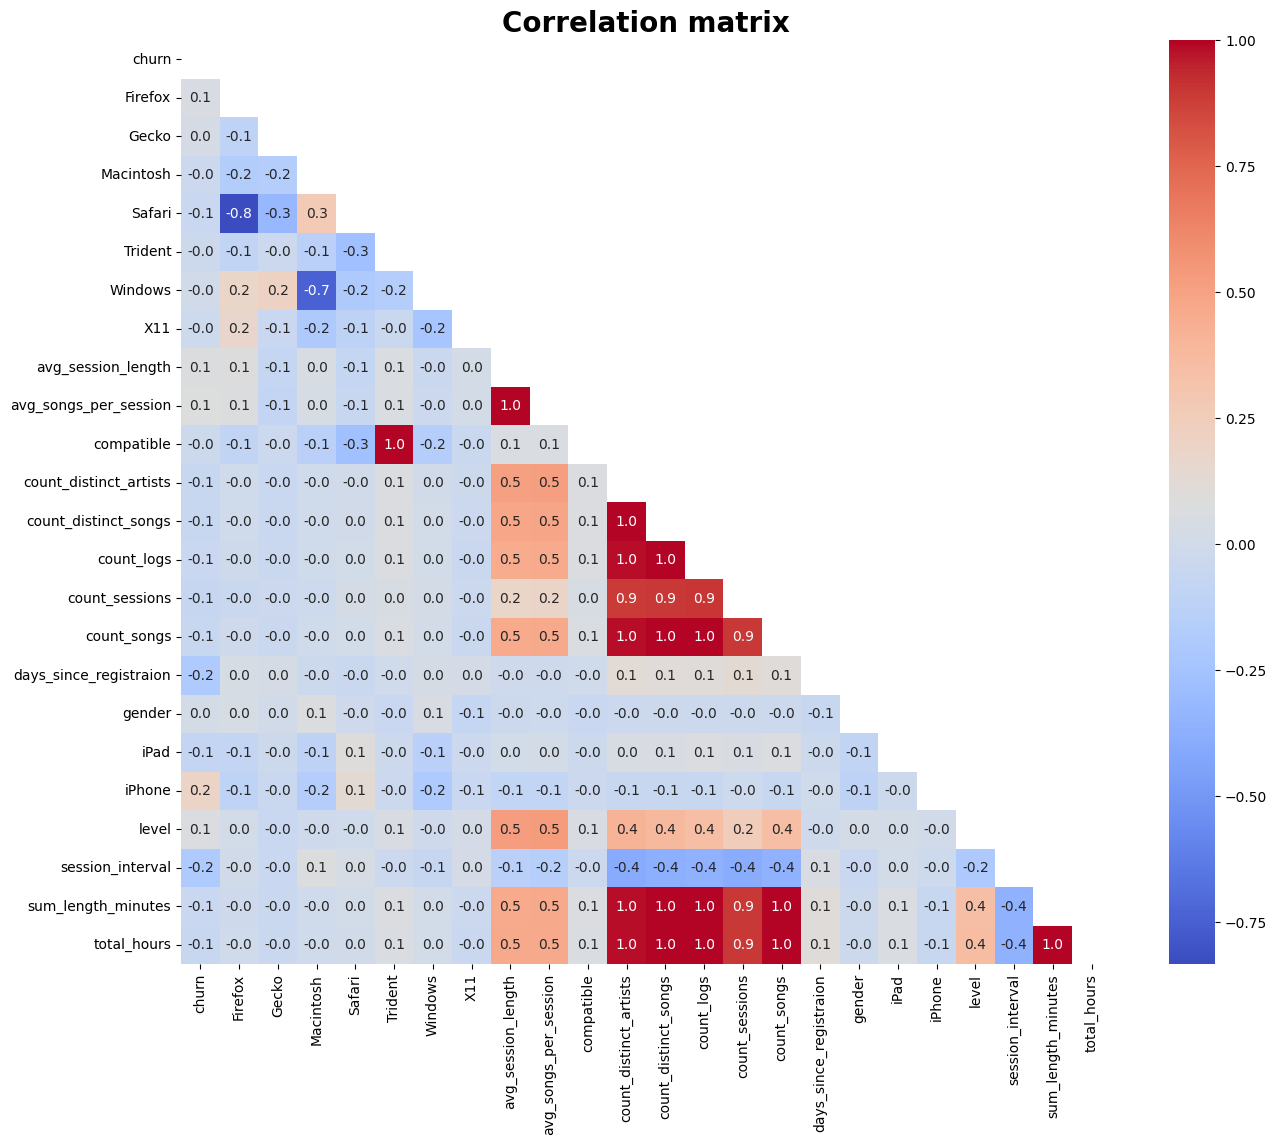

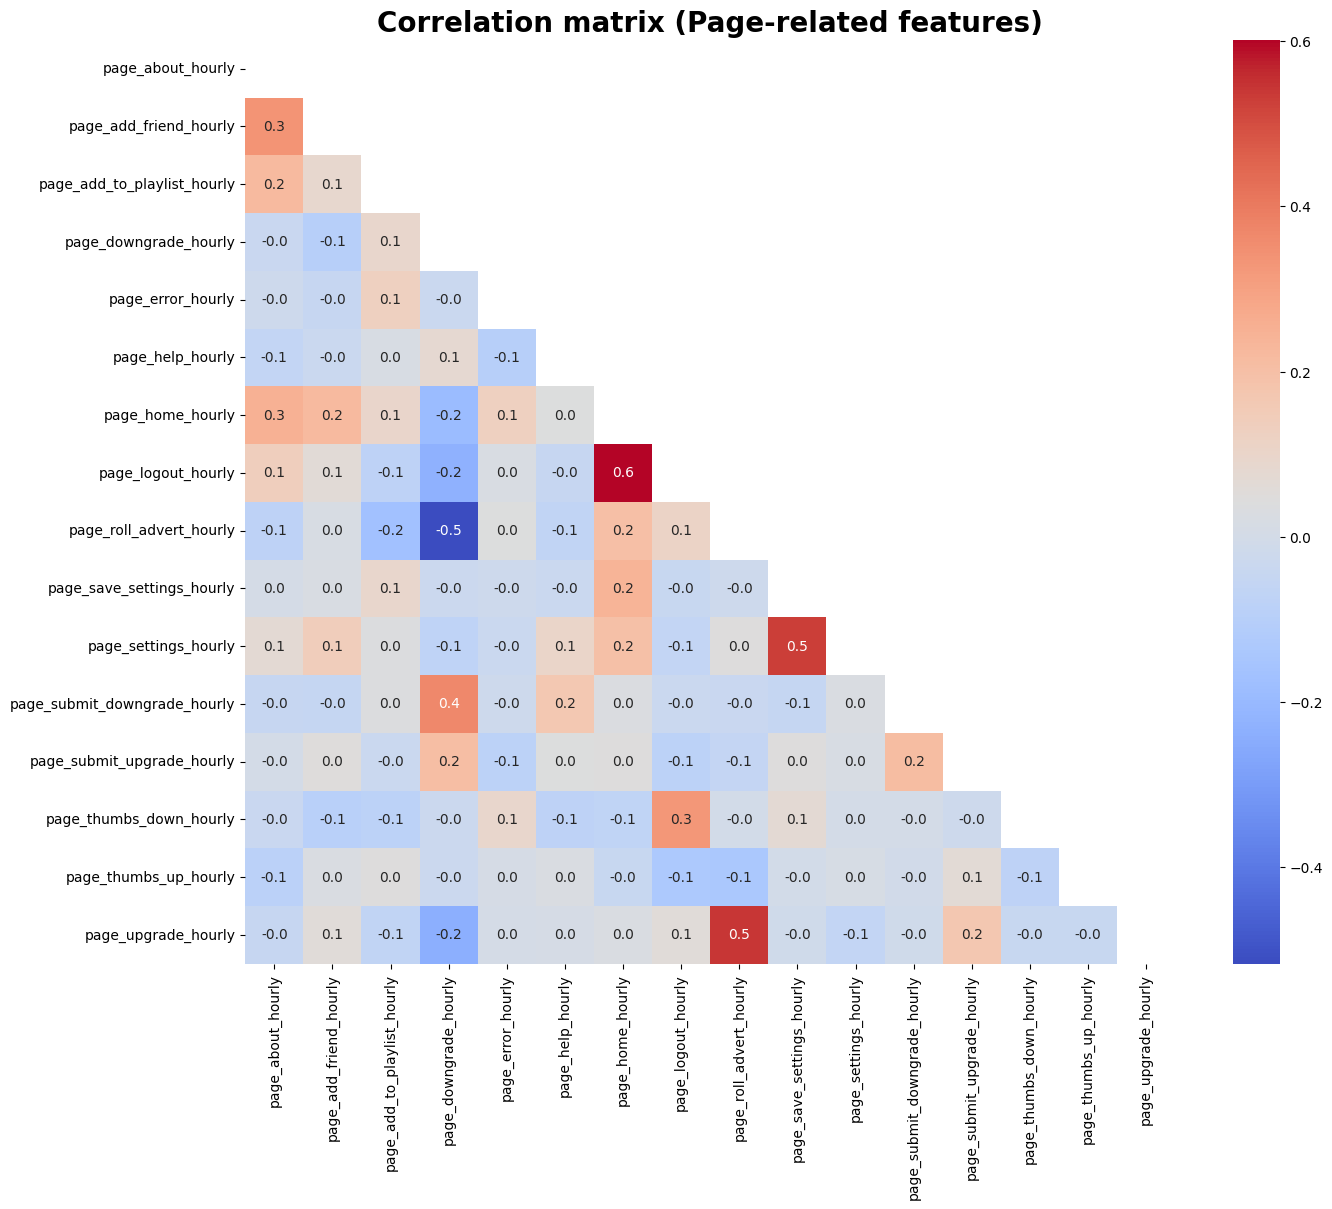

In [75]:
cols = model_df.columns

cols_page = []

for col in model_df.columns:
    if col.startswith("page_"):
        try:
            cols.remove(col)
            cols_page.append(col)
        except:
            pass
        
# 1. Correlation of non-page related features           
corr_matrix = model_pd[cols].drop(columns=['userId']).corr(numeric_only=True)

mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True    # data will not be shown in cells where `mask` is True

plt.figure(figsize=(15,12))    
sns.heatmap(corr_matrix,mask=mask,annot=True,fmt='.1f', cmap='coolwarm') 
plt.title("Correlation matrix", size = 20, weight = 'bold');

# 2. correlation of page-related features
corr_matrix = model_pd[cols_page].corr(numeric_only=True)

mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True    # data will not be shown in cells where `mask` is True

plt.figure(figsize=(15,12))    
sns.heatmap(corr_matrix,mask=mask,annot=True,fmt='.1f', cmap='coolwarm') 
plt.title("Correlation matrix (Page-related features)", size = 20, weight = 'bold');

🔑 **Note:**<br> It is clear that there is a strong correlation between many features. For instance, 'count_logs', 'count_sessions', 'count_songs' are higly correlated.<br>
In the next section, we will proceed to `Feature selection`.

### Feature Selection

[Feature selection techniques](https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/), as the name suggests, is the process of selecting features without transforming them (unlike [PCA](https://machinelearningmastery.com/principal-components-analysis-for-dimensionality-reduction-in-python/)), whose new principal components are not uninterpretable). 
The main benefits of this process are to simplify the model, reduce training time and avoid overfitting.


Here are the steps we will be taking:
1. Removing highly correlated features.
2. Univariate feature selection: We will use the [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) library.

#### 1. Removing highly correlated features

Removing highly correlated features both reduces the number of features and improves model performance.

Using the correlation matrix (displayed above) can help us remove highly correlated features. <br>
Let us create a function to **automatically** detect and remove these features.

In [84]:
# Find correlated features that have absolute correlation >= 0.5
dataset_pd = model_pd.drop(columns=['userId'])

corr_matrix = dataset_pd.corr()
correlated_columns = []
for coln in corr_matrix.columns:
    correlated = corr_matrix.drop(coln, axis=0).loc[corr_matrix[coln].abs()>=0.5].index.tolist()
    if len(correlated) > 0:
        correlated_columns.append(coln)      
        
# Find features to be removed, i.e. feature that has >0.8 correlation with any remaining feature
corr = dataset_pd[correlated_columns].corr()
columns_to_remove = []
index_ = 0
for col in corr.columns:
    index_ += 1
    if corr[col].iloc[index_:].max() >= 0.8:
        columns_to_remove.append(col)
        
        
print(f"{len(columns_to_remove)} highly correlated features are removed:\n\n{columns_to_remove}\n\n")

features_to_keep = dataset_pd.columns.drop(columns_to_remove).tolist()

print(f"{len(features_to_keep)} Features to keep including 'churn':\n\n{features_to_keep}")

8 highly correlated features are removed:

['Trident', 'avg_session_length', 'count_distinct_artists', 'count_distinct_songs', 'count_logs', 'count_sessions', 'count_songs', 'sum_length_minutes']


32 Features to keep including 'churn':

['churn', 'Firefox', 'Gecko', 'Macintosh', 'Safari', 'Windows', 'X11', 'avg_songs_per_session', 'compatible', 'days_since_registraion', 'gender', 'iPad', 'iPhone', 'level', 'page_about_hourly', 'page_add_friend_hourly', 'page_add_to_playlist_hourly', 'page_downgrade_hourly', 'page_error_hourly', 'page_help_hourly', 'page_home_hourly', 'page_logout_hourly', 'page_roll_advert_hourly', 'page_save_settings_hourly', 'page_settings_hourly', 'page_submit_downgrade_hourly', 'page_submit_upgrade_hourly', 'page_thumbs_down_hourly', 'page_thumbs_up_hourly', 'page_upgrade_hourly', 'session_interval', 'total_hours']


#### 2. Univariate feature selection

After detecting the highly correlated features, we are left with **30** features. We need to select the best ones (churn is the target).

[Univariate selection](https://www.analyticsvidhya.com/blog/2021/06/feature-selection-techniques-in-machine-learning-2/#Univariate_selection) is a statistical test, such as `chi-square`, used to select the best features most closely related to the target variable. 

We will use the [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) library, which selects features based on the k highest scores.

In [85]:
from sklearn.feature_selection import SelectKBest, chi2

def feature_selection(data,num_best_features = 16):
    '''
    Selects features based on the k highest scores. The higher the score, the more important the feature is.
    INPUTS:
        num_best_features (int): number of best features to select, defualt =16.
        data (Spark DF): the Spark data frames containg the features
    
    OUTPUTS
        selected_best_features (list): List of the selected best features.
        featureScores (Pandas DF): DF containg the highest scores.
    '''
    for cols in data.columns.tolist():
        data = data[data[cols] >= 0] # To handle error "Input X must be non-negative"
    
    X = data.drop(columns=['churn'])  
    Y = data['churn']

    X_best= SelectKBest(chi2, k=num_best_features).fit(X, Y)

    # Creat Pandas DF with features and scores.
    featureScores = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(X_best.scores_)],axis=1)
    featureScores.columns = ['Feature','Score']  
    featureScores = featureScores.sort_values(by=['Score'],ascending=False)[:num_best_features].set_index("Feature")
    
    selected_best_features = list(featureScores.index)
    
    return selected_best_features,featureScores

In [78]:
# Select best features

# num_best_features = len(features_to_keep)-1 # select all features
num_best_features = 16 # select Top 16 features

selected_best_features,featureScores = feature_selection(model_pd[features_to_keep], num_best_features = num_best_features)

print(f"The selected {num_best_features} features are:\n\n{selected_best_features}.\n\nThe scores are:")
featureScores

The selected 16 features are:

['session_interval', 'days_since_registraion', 'total_hours', 'avg_songs_per_session', 'iPhone', 'page_roll_advert_hourly', 'iPad', 'page_upgrade_hourly', 'page_downgrade_hourly', 'level', 'Firefox', 'page_logout_hourly', 'Macintosh', 'page_submit_upgrade_hourly', 'Gecko', 'compatible'].

The scores are:


,Score
Feature,
session_interval,166244.488118
days_since_registraion,311.418612
total_hours,105.373137
avg_songs_per_session,66.386842
iPhone,16.148193
page_roll_advert_hourly,8.801372
iPad,2.527221
page_upgrade_hourly,1.588246
page_downgrade_hourly,0.927498


**How many features could we choose to have a simple model and avoid over-fitting?**

🔑 To keep it simple and get the best results, we will be building a series of K-fold cross validators using MLlib classifiers and various `N` selected features.<br>
```N = range(4,len(features_to_keep)-1,4)``` As it would take too long to test all the values, we choose a step of 4.

# <a name="modelling"></a> Modeling
Train-test split, Pipeline creation, cross-validation, class weighting to tackle the imbalance problem, training, hyperparameter tuning, and evaluation of the model are covered in this section.<br>
We will use the [PySpark ML](https://spark.apache.org/docs/latest/ml-classification-regression.html) algorithms: LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC and DecisionTreeClassifier.<br>
Due to our unbalanced dataset, we will use the **f1-score** as evaluation metric.

## Evalutaion metric

Our dataset has **unbalanced classes**, as there are only **22%** churners, which means that the model has more information about active users (the majority class) than churners (the minority class). <br>
If the model always predicts for active users, we get a good accuracy of 78%. However, this hides the true performance of the classifier, which never identifies a churn.
**Accuracy is thus misleading and should not be used here**.<br>
Instead, we will use the **F1-score** as evaluation metric, which **combines precision and recall** into one metric as follows:<br>

$$F_1 = \frac{2*precision*recall}{precision + recall}$$<br>
where:
- **Precision** is the proportion of correctly predicted churners (true positives) out of the total number of predicted churners.<br> ```Higher precision leads to fewer false positives (the model predicts churn when it shouldn't have).```
- **Recall** is the proportion of correctly predicted churners out of the total number of real churners.<br> ```Higher recall leads to fewer false negatives (the model predicts no churn when it should've been churn).```


From a business perspective, higher recall and precision means that all discounts or marketing promotions are effectively targeted at people at risk of leaving.

Finally, it is worth noting that using the f1 score as an evaluation metric is not a solution to the imbalance problem.<br>There are some techniques to solve this problem, such as `resampling`, generating synthetic data for the minority class (`SMOTE`), and `balancing class weights`.<br>
[balancing class weights](https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/), which we will use to enhance the performance of our models, is nothing more than giving the minority class a higher weight and reducing the weight of the majority class.

### Assign class weights to handle class imbalance

In [79]:
labels = [0,1]
count_users = model_df.count()

weights = dict()
for label in labels:
    count_label = model_df.filter(model_df['churn']==label).count()
    weight = count_users/(count_label*len(labels))
    weights[label]=weight

model_df = model_df.withColumn('weight', f.when(f.col('churn') == 1, weights[1]).otherwise(weights[0]))

model_df.select("userId","churn","weight").show(5)

+------+-----+------------------+
|userId|churn|            weight|
+------+-----+------------------+
|    10|    1|2.2626262626262625|
|   100|    0|0.6418338108882522|
|100001|    1|2.2626262626262625|
|100002|    0|0.6418338108882522|
|100003|    1|2.2626262626262625|
+------+-----+------------------+
only showing top 5 rows



We can see that higher weights are given to the churners (the minority class).

## Train-Test split

In [86]:
def split_data(data, weights=[0.7,0.3], seed=42):
    """
    Splits data into training and testing subset, where .
    
    Args:
        data (DataFrame): The model data with features.
        seed (int): A seed value of the random number generator, default =42.
        weights (List[float]): split ratio, default: [0.7,0.3]
        
    Returns:
        train_df (DataFrame): The training subset.
        test_df (DataFrame): The testing subset.
    """
    train_df, test_df = data.randomSplit(weights, seed=seed);
    return train_df, test_df

# train_df, test_df = split_data(model_topfeatures,weights=[0.7,0.3], seed=42)

## Pipeline and CrossValidator
First, we will create a `pipeline` which includes:
1. **VectorAssembler**, which efficiently merges our features into a vector column, using less memory as described [here](https://community.databricks.com/t5/data-engineering/why-do-spark-mllib-models-only-accept-a-vector-column-as-input/m-p/24271#:~:text=The%20modeling%20algorithms%20in%20Spark,be%20handled%20with%20less%20memory.).
2. **MinMaxScaler**, which rescales each feature to the range between 0 and 1, so that a column with lower values is as important to the model as a column with higher values.
3. **MLlib classifier**: a classifier of choice.

A `CrossValidator` is then created.

In [87]:
def create_CrossValidator(classifier,data,isCV=True, paramGrid=None, numFolds=5,is_class_weight=False):
    '''
    Create a pipeline. If isCV is True, create a CrossValidator. 
    The pipeline includes MinMaxScaler, VectorAssembler and a classifier.
    
    INPUTS:
        classifier: A machine learning classifier object. This is the last stage in the pipeline.
        data (Spark DF): a dataframe with statistics per user.        
        isCV (boolean): whether or not a cross-validator is returned. If not, the pipeline is returned.
        paramGrid: a ParamGridBuilder object with hyperparameters.
        numFolds (int): number of folds of the CrossValidator, defualt=5.
        is_class_weight (boolean): whether class weighting is performed or not, default=False
        
    OUTPUT:
        crossval or pipeline: the CrossValidator or the pipeline, depending on the isCV parameter.
    '''
    # 1. Transform numerical features into a Vector structure  
   
    features = data.columns[2:-1] # the first two columns: 'userId' and 'churn'. The last column is:'weight'
        
    assembler = VectorAssembler(inputCols=features, outputCol="num_features") 

    # 2. Create a scaler object : MinMaxScaler
    scaler = MinMaxScaler(inputCol="num_features",outputCol="features") 
    # scaler = StandardScaler(withMean=True, withStd=True,inputCol="num_features",outputCol="features")
    
    # 3. Setup the pipeline
    pipeline  = Pipeline(stages = [assembler, scaler,classifier])    
    
    # 4. Cross validation
    crossval = pipeline  # ifCV = Flase return the pipeline
    
    if isCV:             
        crossval = CrossValidator(
            estimator=pipeline,
            estimatorParamMaps=paramGrid,
            evaluator=MulticlassClassificationEvaluator(labelCol="churn",metricName='f1'),
            numFolds=numFolds,
            seed=42,
        )        
    
    return crossval 

We are now going to create two functions for **training** and **evaluating** our models.

In [89]:
def train_model(classifier_name, crossval,data,print_msg=True):
    '''
    Train a cross validator.
    
    INPUT
        classifier_name: the name of the classifier
        crossval: the CrossValidator.
        data: the Spark DataFrame.
        print_msg (boolean): print message onto the screen.
    
    OUTPUT
        model: trained machine learning model
        training_time (float): the model's training time
    '''
    if print_msg:
        print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}. Train {classifier_name} ...")
        
    start = time()
    
    # fit the model to the data
    model = crossval.fit(data)
    
    end = time()
    training_time = end - start
    
    return model, training_time

def evaluate_model(model,model_name,train,test,training_time,isCV=True,
                   paramGrid=None,best_params=None,num_best_features=16,seed=42,print_msg=True,num_params=None):    
    '''
    Evaluate model performance.
    
    INPUT
        model: trained machine learning model
        model_name: the model name
        train,test (Spark dataframe): the train and test dataframe.
        training_time (float): the model's training time
        isCV (boolean): whether a Cross Validation is used or not.
        paramGrid (list): parameter grid for hyperparameter tuning.
        best_params (dict): best hyperparameters of the CrossValidator.
        seed (int): the seed used to randomly split data into train and test datasets.
        num_best_features (int): the number of features selected to feed the model.
        print_msg (boolean): print message onto the screen
        num_params (int): number of the parameters in the paramGrid
    
    OUTPUT
        evaluation_metrics (dict): disctionary of evaluation metrics, including:
                                accuracy, f1-score, precision, recall and AUC.
    '''
    #print(f"Eval  {model_name} ... {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    # 1. make predictions
    predictions = model.transform(test)  
    predictions_train = model.transform(train)
    
    # 2. Instantiate MulticlassClassificationEvaluator and BinaryClassificationEvaluator
    evaluator = MulticlassClassificationEvaluator(labelCol="churn",metricName="f1")
    evaluator_auc = BinaryClassificationEvaluator(labelCol='churn', rawPredictionCol='prediction', metricName='areaUnderROC')
    
    # 3. Evaluate test and train
    evaluation_metrics = {}
    evaluation_metrics["model"] = model_name
    evaluation_metrics["accuracy"] = evaluator.evaluate(predictions, {evaluator.metricName:"accuracy"})
    evaluation_metrics["accuracy (train)"] = evaluator.evaluate(predictions_train, {evaluator.metricName:"accuracy"})
    
    evaluation_metrics["f1_score"] = evaluator.evaluate(predictions)    
    evaluation_metrics["f1_score (train)"] = evaluator.evaluate(predictions_train)  
    
    if print_msg:
        print(f"  F1-score test ({model_name}) :{evaluation_metrics['f1_score']} ")
        print(f"  F1-score train ({model_name}) :{evaluation_metrics['f1_score (train)']} ")
    
    evaluation_metrics["precision"] = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    evaluation_metrics["recall"] = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    evaluation_metrics["auc"] = evaluator_auc.evaluate(predictions)
    evaluation_metrics["auc (train)"] = evaluator_auc.evaluate(predictions_train)
    
    evaluation_metrics["training_time"] = training_time
    evaluation_metrics["CrossValidation"] = isCV
    evaluation_metrics["paramGrid"] = paramGrid
    evaluation_metrics["num_params"] = num_params
    evaluation_metrics["best_params"] = best_params
    evaluation_metrics["num_best_features"] = num_best_features
    evaluation_metrics["seed"] = seed
    
    return evaluation_metrics  

Now, let's create a function to display **feature importance.**

In [90]:
# Get feature coefficinets

def get_feature_coefficinets(model,data, classifier_name):
    '''
    get feature coefficients of a model.
    
    INPUT:
        model: MLlib classifier
        data: Sparak dataframe
        classifier_name: classifier name
        
    Output:
        feature_coef_df (Pandas DF): a Pandas Dataframe with feature names and coefficients.        
    '''
     
    feature_cols = data.drop('userId','churn').columns
    
    if classifier_name=="LogisticRegression":
        feature_coef = model.coefficients.values.tolist()
        feature_name = feature_cols
    
    else:
        feature_coef = model.featureImportances.values.tolist()
        feature_ind = model.featureImportances.indices.tolist()
        feature_name = [feature_cols[ind] for ind in feature_ind]  
    
    feature_coef_df = pd.DataFrame(list(zip(feature_name, feature_coef)), columns=['Feature', 'Coefficient'])\
                    .sort_values('Coefficient', ascending=False)
          
    return feature_coef_df



# Display coeffecients with Plotly

def plotly_feature_coeffecients(data,x, y,title,template="plotly_dark",height=600):
    """
    Plots a bar chart using plotly
    imputs: 
            data: a dataframe containing features and coeffecients
            x : feature column
            y : coefficients column
            title: title of the graph
            template : possible values ["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"] 
            height: height of the graph. Default =600
    """
    
    fig = px.bar(x=x, y=y,data_frame=data, 
                 template=template,
                 height=height,color=y,
                 title = title,
                )
    fig.update_layout(
        title_text=f"<b>{title}</b>",
        title_x=0.5,# title position
#         font=dict(
#             #family="Times New Roman",
#             size=12,
#             color="black"
#         )  
    )
    fig.show();

## Model selection

The algorithms we want to compare are: `NaiveBayes`, `LogisticRegression`,`RandomForestClassifier`,`GBTClassifier`, `LinearSVC` and `DecisionTreeClassifier`.

To build our models, we will be going through the following steps:
1. Instantiate the classifiers mentioned above.
2. Fit the model to the training data (training_df using **train_model** function.
3. Evaluate each model using **evaluate_model** function.

To handle all these steps, we will create a function `train_eval_withCV` .

In [91]:
def convert_paramGrid_to_list(paramGrid):
    '''
    convert ParamGrid structure to a simplified list.
    Example : paramGrid_gbt = ParamGridBuilder().addGrid(gbt.maxIter, [20, 40]).addGrid(gbt.maxDepth,[4, 5]).build()
              output : ['maxIter : [20, 40]', 'maxDepth : [4, 5]']
              
    INPUTS:
        paramGrid: the ParamGridBuilder
    
    OUTPUTS:
        params_list (list): list of parameters.
    
    '''    
    paramGrid_pd = pd.DataFrame([{p.name: v for p, v in m.items()} for m in paramGrid])
    params_list = []
    for col in paramGrid_pd:
        params_list +=[f"{col} : {list(paramGrid_pd[col].unique())}"]
        
    return params_list

def train_eval_withCV(model_df,model_pd,features_to_keep,paramGrid,classifier_list,
                      classifier_names,seed=42,isCV=True,num_Folds=5,num_best_features=10,
                      save_results=False,print_msg=True,is_class_weight=False):
    '''
    train and eval model using Cross Validation. `train_model` and `evaluate_model` are called.
    The steps are as follows:    
        1. Select K best features using SelectKBest, where k is the num_best_features(default = 10).
        2. train test split.
        3. Train and evaluate the models
        4. save results
        
    INPUTS:
        model_df (Spark DF): trained machine learning model
        model_pd (pandas DF): the equivalent Pandas DF
        features_to_keep: the feature to keep after dropping highly correlated features.
        paramGrid (dict): parameter grid for hyperparameter tuning.
        classifier_list (list): list of MLlib classifiers (LogisticRegression, RandomForestClassifier,...)
        classifier_names (list): list of MLlib classifier names
        seed (int): the seed used in `randomSplit`, default=42
        isCV (boolean): whether a Cross Validation is used or not.
        num_Folds (int): number of folds of the Cross validator.
        num_best_features (int): the number of features selected to feed the model.
        save_results (boolean): wether or not evaluation results are saved.
        print_msg (boolean): print message onto the screen
        is_class_weight (boolean): whether there are class weights or not.
        
    OUTPUT:
        metrics_df (Pandas DF): DF containing evaluation results.
        models_list (list): list of created MLlib models
        selected_best_features (list): list of selected best features (using SelectKBest).
        model_topfeatures (Spark DF): DF containing the selected best features      
    '''

    # 1. Select best features
    selected_best_features,_ = feature_selection(model_pd[features_to_keep], num_best_features)
    
    model_topfeatures = model_df.select(["userId","churn"] + selected_best_features )  
        
    if is_class_weight:
        model_topfeatures = model_df.select(["userId","churn"] + selected_best_features + ["weight"])

    # 2. train test split
    train_df, test_df = split_data(model_topfeatures,seed=seed)
    # train_df, test_df = stratifiedSampler(model_topfeatures, ratio=0.7, label="churn", joinOn="userId",seed=seed)

    metrics_list = []
    models_list = []
    
    # 3. Train and evaluate the models

    for i in range(len(classifier_list)):
        crossval = create_CrossValidator(classifier_list[i],train_df,isCV,paramGrid[i],numFolds=num_Folds,
                                        is_class_weight = is_class_weight)

        # 3.1. train the model
        model,training_time = train_model(classifier_names[i],crossval,train_df,print_msg=print_msg)  

        # 3.2. Get best params (hig score)
        if isCV:
            scores = model.avgMetrics
            best_params = [{p.name: v for p, v in m.items()} for m in model.getEstimatorParamMaps()][np.argmax(scores)]
        else:
            best_params = None

        # 3.3. Evaluate the model
        params_list = convert_paramGrid_to_list(paramGrid[i])
        num_params = len(paramGrid[i]) # Get the number of parameters in the paramGrid (=length of all combinations)
        
        metrics = evaluate_model(model, classifier_names[i], train_df, test_df, training_time,
                                 isCV,params_list,best_params,num_best_features,seed=seed,
                                 print_msg=print_msg,num_params=num_params) 

        metrics_list.append(metrics)
        models_list.append(model)
    
    metrics_df = pd.DataFrame(metrics_list)

    # 4. save metrics
    if save_results:
        path = "./metrics/metrics_CV_"+str(num_best_features)+"features_seed"+str(seed)+".csv"
        metrics_df.to_csv(path, index=False)
    
    return metrics_df, models_list,selected_best_features,model_topfeatures

**Before we run our experiments, let's create a function to display our metrics, more specifically f1-score and training time vs. number of features selected or seed.**

In [3]:
def plot_metrics(metrics_df,models_list,column_="num_best_features"):
    '''
    Display f1-score and training time vs. 'column_', where 'column' is 'num_best_features' or 'seed'.
    INPUT:
        metrics_df (Pandas DF): Dataframe contating f1-score,training time, seed and number of features.
        models_list (list): list of models to dipsplay.
        column_ (string): 'num_best_features' or 'seed' , default="num_best_features"
    OUTPUT:
        None.
    '''

    # Create pivot tables. This allows Plotly to plot multiple lines on the same Y-axis
    # f1_stats = pd.pivot_table(metrics_df, values='f1_score', index=['num_best_features'],columns='model', aggfunc=np.mean)
    f1_stats = pd.pivot_table(metrics_df, values='f1_score', index=[column_],columns='model', aggfunc=np.mean)
    f1_stats = f1_stats[models_list]

    # time_stats = pd.pivot_table(metrics_df, values='training_time', index=['num_best_features'],columns='model',aggfunc=np.mean)
    time_stats = pd.pivot_table(metrics_df, values='training_time', index=[column_],columns='model',aggfunc=np.mean)
    time_stats = time_stats[models_list]

    # Make subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=("f1_score","training_time") )
    cols = plotly.colors.DEFAULT_PLOTLY_COLORS # Plotly default colors

    # Display f1-score
    i = 0 #index
    for col in time_stats.columns:  
        fig.add_trace(go.Scatter(x=f1_stats.index, y=f1_stats[col],
                                 name = col,
                                 mode = 'markers+lines',
                                 line=dict(width=2, color=cols[i]),
                                ),
                      row=1, col=1
                     )
        i+=1
    fig.layout.annotations[0].update(y=1.025)

    # Display training time
    i = 0 #index
    for col in time_stats.columns:
        fig.add_trace(go.Scatter(x=time_stats.index, y=time_stats[col],
                                 name = col,showlegend=False,
                                 mode = 'markers+lines',
                                 line=dict(width=2, color=cols[i])
                                ),
                      row=1, col=2
                     )
        i+=1
    fig.layout.annotations[1].update(y=1.025)

    # Edit axis labels
    fig['layout']['xaxis']['title']=column_
    fig['layout']['xaxis2']['title']=column_
    fig['layout']['yaxis']['title']='%'
    fig['layout']['yaxis2']['title']='seconds'

    # Update_layout      
    fig.update_layout(
        title_text=f"<b>F1-score and training time vs. {column_}</b>",
        title_x=0.5,
        title_font_color="black",
        font=dict(color="black")  ,
        margin=dict(r=25, l=25),
        height=500,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.4,
            xanchor="right",
            x=0.925,
            #bgcolor="lightGray"
        )
    )

    fig.show()

### Train and eval classifiers vs. num selected features - with class weighting
We assign the `weigt` to the `weightCol` parameter of the MLlib classifiers.  

In [63]:
# 1. initialize classifiers
rfc = RandomForestClassifier(featuresCol="features",labelCol="churn",weightCol="weight",seed=42)
lr = LogisticRegression(featuresCol="features",labelCol="churn",weightCol="weight")
gbt = GBTClassifier(featuresCol="features",labelCol="churn",weightCol="weight",seed=42)
svc = LinearSVC(featuresCol="features",labelCol="churn",weightCol="weight")
dt = DecisionTreeClassifier(featuresCol="features",labelCol="churn",weightCol="weight",seed=42)

classifier_list = [rfc,lr,gbt,svc,dt]
classifier_names = ["RandomForestClassifier","LogisticRegression","GBTClassifier","LinearSVC","DecisionTreeClassifier"]

# 2. Param Grid
paramGrid = []
for ii in range(len(classifier_list)):
    paramGrid += [ParamGridBuilder().build()] # set the default ParamGrid 

# 3. define seed_list and list_num_best_features

seed_list = [42]
list_num_best_features = range(4,len(features_to_keep)-1,4)

# 4. initialise all_metrics_df : a dataframe that will concatenate all metrics.
all_metrics_df = pd.DataFrame(columns=['model', 'accuracy', 'accuracy (train)', 'f1_score', 'f1_score (train)',
                                       'precision', 'recall', 'auc', 'auc (train)', 'training_time',
                                       'CrossValidation', 'paramGrid', 'best_params', 'num_best_features','seed'
                                      ])
all_metrics_df['CrossValidation'] = all_metrics_df['CrossValidation'].astype('bool')
all_metrics_df['seed'] = all_metrics_df['seed'].astype('int')

for seed in seed_list:
    # for each num_best_features, generate a metrics DF, that will be concatenated with all_metrics_df
    for num_best_features in list_num_best_features:
        time_now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print(f"{time_now}. Number of selected features = {num_best_features} and seed = {seed}. Please wait...")
        try:
            metrics_df, _,_,_ = train_eval_withCV(model_df,model_pd,features_to_keep,paramGrid,classifier_list,
                                                  classifier_names,seed=seed,isCV=True,num_Folds=5,
                                                  num_best_features=num_best_features,save_results=False,
                                                  print_msg=False,is_class_weight=True)

            all_metrics_df = pd.concat([all_metrics_df,metrics_df])
        except:
            pass
    
all_metrics_df = all_metrics_df.reset_index().drop("index",axis=1)

# 5. save results
all_metrics_df.to_csv("./metrics/medium_GridCV_classWeight.csv",index=False)

print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Show top 5 results
# all_metrics_df.sort_values("f1_score",ascending=False)[:5]

2023-08-07 22:23:04. Number of selected features = 4 and seed = 42. Please wait...
2023-08-07 22:24:58. Number of selected features = 8 and seed = 42. Please wait...
2023-08-07 22:27:18. Number of selected features = 12 and seed = 42. Please wait...
2023-08-07 22:29:35. Number of selected features = 16 and seed = 42. Please wait...
2023-08-07 22:31:45. Number of selected features = 20 and seed = 42. Please wait...
2023-08-07 22:33:51. Number of selected features = 24 and seed = 42. Please wait...
2023-08-07 22:35:55. Number of selected features = 28 and seed = 42. Please wait...
2023-08-07 22:38:01


In [4]:
# display f1-score and training time vs. num features - with class weighting

models_list = ["RandomForestClassifier","LogisticRegression","GBTClassifier","LinearSVC","DecisionTreeClassifier"]

metrics_classWeight_df = pd.read_csv("./metrics/medium_GridCV_classWeight.csv")
metrics_classWeight_df["training_time"] = metrics_classWeight_df["training_time"]/metrics_classWeight_df["num_params"]
metrics_classWeight_df["class_weight"] = "YES"

plot_metrics(metrics_classWeight_df,models_list)

🔑 **Note:**

- `RandomForestClassifier` and `GBTClassifier ` outperform .

- `RandomForestClassifier`, `LogisticRegression` and `Linear SVC` reach an f1 score of 85% (using less than 20 features). However, the training time differs significantly between these classifiers, being only 9 seconds for the former.

The `RandomForestClassifier` is therefore the winner of this experiment.


### Hyperparameters tuning of cross-validation - with class weights

Here, we try to improve the `f1-score` by tuning the hyperparameters of our classifiers.<br>
- Number of selected features in [6,8,10,12,14,16]
- ParamGridBuilders are defined below.

The combination that returns the best f1-score will be our best model.

In [54]:
# 1. initialize classifiers
rfc = RandomForestClassifier(featuresCol="features",labelCol="churn",weightCol="weight",seed=42)
lr = LogisticRegression(featuresCol="features",labelCol="churn",weightCol="weight")
svc = LinearSVC(featuresCol="features",labelCol="churn",weightCol="weight")
gbt = GBTClassifier(featuresCol="features",labelCol="churn",weightCol="weight",seed=42)

classifier_list = [rfc,lr,svc,gbt]
classifier_names = ["RandomForestClassifier","LogisticRegression","LinearSVC","GBTClassifier"]


# 2. Param Grid
paramGrid_rfc = ParamGridBuilder() \
    .addGrid(rfc.maxDepth, [5,10,15]) \
    .addGrid(rfc.numTrees, [20,50,100]) \
    .build()

paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0,0.1,0.2]) \
    .addGrid(lr.elasticNetParam, [0.0,0.5,1]) \
    .build()

paramGrid_svc = ParamGridBuilder() \
    .addGrid(svc.regParam, [0.0,0.05,0.1,0.2])\
    .build()

# paramGrid_gbt = ParamGridBuilder() \
#     .addGrid(gbt.maxIter, [20,50,100]) \
#     .addGrid(gbt.maxDepth,[5,10,15]) \
#     .build()
paramGrid_gbt = ParamGridBuilder().build() # The GBT training time is too long. We will keep the default params.


paramGrid = [paramGrid_rfc,paramGrid_lr,paramGrid_svc,paramGrid_gbt]

# 3. define seed_list and list_num_best_features

seed_list = [42] 
list_num_best_features = range(4,25,4)

# 4. initialise all_metrics_df : a dataframe that will concatenate all metrics.
all_metrics_df = pd.DataFrame(columns=['model', 'accuracy', 'accuracy (train)', 'f1_score', 'f1_score (train)',
                                       'precision', 'recall', 'auc', 'auc (train)', 'training_time',
                                       'CrossValidation', 'paramGrid', 'best_params', 'num_best_features','seed'
                                      ])
all_metrics_df['CrossValidation'] = all_metrics_df['CrossValidation'].astype('bool')
all_metrics_df['seed'] = all_metrics_df['seed'].astype('int')

for seed in seed_list:
    # for each num_best_features, generate a metrics DF, that will be concatenated with all_metrics_df
    for num_best_features in list_num_best_features:
        time_now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print(f"{time_now}. Number of selected features = {num_best_features} and seed = {seed}. Please wait...")
        try:
            metrics_df, models_list,selected_best_features,model_topfeatures=\
            train_eval_withCV(model_df,model_pd,features_to_keep,paramGrid,classifier_list,
                              classifier_names,seed=seed,isCV=True,num_Folds=5,
                              num_best_features=num_best_features,save_results=False,
                              print_msg=False,is_class_weight=True)

            all_metrics_df = pd.concat([all_metrics_df,metrics_df])
        except:
            pass
    
all_metrics_df = all_metrics_df.sort_values("f1_score",ascending=False).reset_index().drop("index",axis=1)

# 5. save results
all_metrics_df.to_csv("./metrics/medium_GridCV_classWeight_tuning.csv",index=False)

print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Show top 5 results
# all_metrics_df.sort_values("f1_score",ascending=False)[:5]

2023-08-07 21:30:28. Number of selected features = 4 and seed = 42. Please wait...
2023-08-07 21:36:22. Number of selected features = 8 and seed = 42. Please wait...
2023-08-07 21:42:52. Number of selected features = 12 and seed = 42. Please wait...
2023-08-07 21:49:28. Number of selected features = 16 and seed = 42. Please wait...
2023-08-07 21:55:44. Number of selected features = 20 and seed = 42. Please wait...
2023-08-07 22:01:51. Number of selected features = 24 and seed = 42. Please wait...
2023-08-07 22:08:00


In [96]:
# display f1-score and training time vs. num features - with class weighting

models_list =  ["RandomForestClassifier","LogisticRegression","LinearSVC","GBTClassifier"]

metrics_classWeight_df = pd.read_csv("./metrics/medium_GridCV_classWeight_tuning.csv")
metrics_classWeight_df["training_time"] = metrics_classWeight_df["training_time"]/metrics_classWeight_df["num_params"]
metrics_classWeight_df["class_weight"] = "YES"

plot_metrics(metrics_classWeight_df,models_list)

best_model = metrics_classWeight_df.sort_values("f1_score",ascending=False)[:1][["model","best_params","num_best_features"]]
print(f"The best model is {best_model.model.values[0]}:")

The best model is RandomForestClassifier:


**Now let's display the feature importance for our best model (RFC using 16 features, where maxDepth=5 and numTrees=100).**

In [97]:
# feature importance

num_best_features = 12
rfc = RandomForestClassifier(featuresCol="features",labelCol="churn",weightCol="weight",seed=42,
                             maxDepth=5,numTrees=100)
classifier_list = [rfc]
classifier_names = ["RandomForestClassifier"]

# 2. Param Grid
paramGrid = [ParamGridBuilder().build()]
metrics_df, models_list,selected_best_features,model_topfeatures=\
    train_eval_withCV(model_df,model_pd,features_to_keep,paramGrid,classifier_list,
                      classifier_names,seed=42,isCV=True,num_Folds=5,
                      num_best_features=num_best_features,save_results=False,
                      print_msg=False,is_class_weight=True)


feature_coef_df = get_feature_coefficinets(models_list[0].bestModel.stages[-1],model_topfeatures,classifier_names[0])
plotly_feature_coeffecients(data=feature_coef_df,x="Feature", y="Coefficient",template="plotly", 
                            height = 500,title=f"Feature importance - {classifier_names[0]}"   )

🔑 **Note:**

- `Random Forest` and `GBT classifiers`, outperform `Linear SVC` and `Logistic Regression` as they only need 8 features to achieve an f1 score of around **85%**. <br>
- The best f1-score is **87%**. It was obtained using the `Random Forest` and 12 features.<br>
- Interestingly, the `RFC classifier` performed well on both the small and medium datasets, with peaks above **87%**.<br>
- The `GBT classifier` performed better on the medium dataset than on the small one (**85%** and **82%** respectively). 
- The most important features show that customer behavior, days since registration and exposure to advertising are the main drivers of churn. 